In [1]:
import os
import numpy as np
import torch
from torchsummary import summary
from torch.utils.data import DataLoader
from generate_data import generate_vrp_data
from utils import load_model
from problems import CVRP

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

In [3]:
# %cd F:/dr6ke/attention-learn-to-route-master-core4
model, _ = load_model('pretrained/cvrp_100')
torch.manual_seed(1234)


  [*] Loading model from pretrained/cvrp_100\epoch-72.pt


In [4]:
dataset = CVRP.make_dataset(size=100, num_samples=1000)
dataloader = DataLoader(dataset, batch_size=1000)
batch = next(iter(dataloader))
model.eval()
model.set_decode_type('greedy')
with torch.no_grad():
    length, log_p, pi = model(batch, return_pi=True)
tours = pi

In [34]:
# batch['depot'] = torch.tensor(np.ones((100, 2)) / 2., dtype=torch.float32)

In [35]:
# model.eval()
# model.set_decode_type('greedy')
# with torch.no_grad():
#     length, log_p, pi = model(batch, return_pi=True)
# tours = pi

In [109]:
print('SA-ECO, avg:', np.average(length), 'min:', min(length))

SA-ECO, avg: 17.294973 min: tensor(12.6345)


In [38]:
W_data = 100 # W
W_fly = 50  # W
V_data = 1024  # kb/s
T_data = 524288  # kb
v_work = 11.55  # v
# W_start = 0.3 * 3600  # Ws
battery = 2.65  # Ah
battery_enery = battery * v_work
WIDTH = 1000
V_fly = 2

In [39]:
def cal_avg_work(length, batch):
    demand_total = np.sum(batch['demand'].numpy(), axis=1)
    fly = WIDTH / V_fly * length.numpy() * W_fly  # *25000/3600
    hover = T_data / V_data * demand_total * W_data  # 142.1428
    print('avg flight:', np.average(fly) / 3600., 'avg hover:', np.average(hover) / 3600.)
    return np.average(fly + hover)

In [40]:
def cal_min_work(length, batch):
    demand_total = np.sum(batch['demand'].numpy(), axis=1)
    fly = WIDTH / V_fly * length.numpy() * W_fly
    hover = T_data / V_data * demand_total * W_data
    print('min flight:', np.min(fly) / 3600., 'min hover:', np.min(hover) / 3600.)
    return np.min(fly + hover)

In [110]:
print('100 set SA-ECO, avg:', cal_avg_work(length, batch) / 3600., 'min:', cal_min_work(length, batch) / 3600.)

avg flight: 120.103984375 avg hover: 142.31723090277777
min flight: 87.73925347222222 min hover: 118.89776909722222
100 set SA-ECO, avg: 262.4212152777778 min: 217.21899305555556


In [42]:
dataset = CVRP.make_dataset(size=500, num_samples=1000)
dataloader = DataLoader(dataset, batch_size=100)
batch2 = next(iter(dataloader))
model.eval()
model.set_decode_type('greedy')
with torch.no_grad():
    length2, log_p2, pi2 = model(batch2, return_pi=True)
tours2 = pi2

_log_p: torch.Size([100, 515, 501]) tensor([[[    -inf, -19.5773, -19.5770,  ..., -19.5772, -19.5770, -19.5770],
         [-19.7496, -21.0252, -21.0252,  ..., -21.0252, -21.0252, -21.0251],
         [-19.3011, -19.8039, -19.8039,  ..., -19.8039, -19.8039, -19.8039],
         ...,
         [  0.0000,     -inf,     -inf,  ...,     -inf,     -inf,     -inf],
         [  0.0000,     -inf,     -inf,  ...,     -inf,     -inf,     -inf],
         [  0.0000,     -inf,     -inf,  ...,     -inf,     -inf,     -inf]],

        [[    -inf, -19.4458, -19.1933,  ..., -19.4455, -19.4452, -19.4455],
         [-19.0597, -19.2079, -17.7571,  ..., -19.2078, -19.2057, -19.2076],
         [-18.1962, -18.2762, -14.3785,  ..., -18.2762, -18.2711, -18.2756],
         ...,
         [  0.0000,     -inf,     -inf,  ...,     -inf,     -inf,     -inf],
         [  0.0000,     -inf,     -inf,  ...,     -inf,     -inf,     -inf],
         [  0.0000,     -inf,     -inf,  ...,     -inf,     -inf,     -inf]],

        

In [44]:
print('500 set SA-ECO, avg:', cal_avg_work(length2, batch2) / 3600., 'min:', cal_min_work(length2, batch2) / 3600.)

avg flight: 222.31402777777777 avg hover: 118.33409722222223
min flight: 178.14765625 min hover: 111.36
500 set SA-ECO, avg: 340.6481597222222 min: 299.0576388888889


In [39]:
MAX = 99999
def get_fitness(indi, demand, return_cap=False):
    pos = np.where(indi > 0)[0]
    split = np.where(np.diff(pos) != 1)[0] + 1
    uavs = np.split(indi[pos], split)
    length = 0
    w1 = 0.5
    w2 = 0.25
    used = []
    route_length = []
    for uav in uavs:
        # print(uav)
        cap = 1.0
        elec = 1.0
        init_elec = 0.01
        elec -= init_elec  # 启动耗电
        route = np.hstack(([0], uav, [0]))
        rl = 0
        # print(route)
        for i in range(len(route) - 1):
            cur_idx = int(route[i])
            next_idx = int(route[i + 1])
            # if elec - w1 * (np.sqrt(sum((loc[cur_idx] - loc[next_idx]) ** 2)) + np.sqrt(sum((loc[next_idx] - loc[0]) ** 2))) - w2 * demand[next_idx] > 0:
                # return MAX
                # pass
            cap -= demand[next_idx]
            cur_length = np.sqrt(sum((loc[cur_idx] - loc[next_idx]) ** 2))
            elec -= (demand[next_idx] * w1 + cur_length * w2)
            length += cur_length
            rl += cur_length
        route_length.append(rl)
        used.append([cap, elec])
        # print(cap)
        # print(elec)
        # print('======')
        if cap < -0.1 or elec < -0.1:
            return MAX

    if return_cap:
        return length, used, route_length
    else:
        return length

In [35]:
available = []
for idx in range(1000):
    loc = batch['loc'].numpy()[idx]
    depot = batch['depot'].numpy()[idx]
    loc = np.vstack((depot, loc))
    result = get_fitness(tours[idx], np.append([0], batch['demand'].numpy()[idx]), return_cap=True)
    if type(result) is not int:
        route_idx = 0
        for uu in result[1]:
            print('route', route_idx, 'cap, elec:',1.0 - np.array(uu), 'length:', result[2][int(route_idx)])
            route_idx += 1
        print(' ========= ')
        available.append(idx)
    # if leng < 99999:
    #     print(used)
    #     print('========')
    #     available.append(idx)  1.0 1.0, 500mb=500s, 100w, 50000Ws, 2km=1000s, 50W, 

route 0 cap, elec: [0.93999998 0.99859463] length: 2.0743785703352056
route 1 cap, elec: [0.95999999 0.99148293] length: 2.005931741525891
route 2 cap, elec: [0.93999999 0.99618049] length: 2.06472197596845
route 3 cap, elec: [0.74000001 0.55609028] length: 0.7043611192188419
route 4 cap, elec: [0.88000001 0.98810715] length: 2.152428565747025
route 5 cap, elec: [0.98000001 0.88212214] length: 1.5284885487004127
route 6 cap, elec: [0.86000001 1.0118904 ] length: 2.2875615766423403
route 7 cap, elec: [0.96       0.96970735] length: 1.918829396986058
route 8 cap, elec: [1.00000001 0.91446033] length: 1.6178413129422113
route 9 cap, elec: [0.96       0.87917325] length: 1.556693006725952
route 10 cap, elec: [0.64000001 0.48342213] length: 0.6136885223732584
route 11 cap, elec: [0.56      0.6007954] length: 1.2431816218937624
route 0 cap, elec: [0.33999999 0.28523517] length: 0.42094068420278574
route 1 cap, elec: [1.         0.92127204] length: 1.6450881451906376
route 2 cap, elec: [1.   

route 4 cap, elec: [0.84       1.00534589] length: 2.301383581566159
route 5 cap, elec: [0.94000001 1.00881486] length: 2.115259422649608
route 6 cap, elec: [0.98       0.96906515] length: 1.8762605822383194
route 7 cap, elec: [0.94       0.98884837] length: 2.0353934963082074
route 8 cap, elec: [0.94       1.00725772] length: 2.1090308737065406
route 9 cap, elec: [0.98000001 0.86455064] length: 1.4582025499147853
route 10 cap, elec: [0.66       0.51440655] length: 0.697626199483878
route 0 cap, elec: [1.00000001 0.94281969] length: 1.731278747704513
route 1 cap, elec: [0.69999999 0.51367367] length: 0.614694720309977
route 2 cap, elec: [0.98       0.96604291] length: 1.8641716249474374
route 3 cap, elec: [0.81999999 1.01019632] length: 2.3607853155651624
route 4 cap, elec: [1.         0.97256263] length: 1.8502505312196074
route 5 cap, elec: [0.86       0.99637731] length: 2.225509223253198
route 6 cap, elec: [0.65999999 1.00846011] length: 2.6738404687254707
route 7 cap, elec: [0.999

route 5 cap, elec: [0.98       1.01038185] length: 2.0415274020733376
route 6 cap, elec: [0.94       0.99811892] length: 2.072475683973285
route 7 cap, elec: [0.97999999 0.86237169] length: 1.449486780413698
route 8 cap, elec: [0.97999998 0.81652985] length: 1.2661194439238705
route 9 cap, elec: [1.00000002 0.78516094] length: 1.100643709086965
route 10 cap, elec: [0.6        0.43677527] length: 0.5071010620827614
route 0 cap, elec: [0.42000001 0.35698316] length: 0.5479326310660095
route 1 cap, elec: [1.         0.88262425] length: 1.4904970125270394
route 2 cap, elec: [0.98       1.01159498] length: 2.046379909201602
route 3 cap, elec: [0.92       0.64358999] length: 0.6943599634773625
route 4 cap, elec: [1.         0.98764318] length: 1.9105727333464197
route 5 cap, elec: [0.92000001 1.00643012] length: 2.1457204764398647
route 6 cap, elec: [0.75999999 1.00047392] length: 2.4418957170161635
route 7 cap, elec: [0.98       0.81988996] length: 1.2795598208483765
route 8 cap, elec: [0.9

route 8 cap, elec: [1.00000001 0.79233292] length: 1.129331665029896
route 9 cap, elec: [0.99999999 0.82739153] length: 1.26956612519366
route 10 cap, elec: [0.93999999 0.85887758] length: 1.5155103539501846
route 11 cap, elec: [0.26       0.25316385] length: 0.45265539577589947
route 0 cap, elec: [0.93999999 0.77375397] length: 1.1750159075755395
route 1 cap, elec: [0.99999999 0.94699348] length: 1.7479739234204807
route 2 cap, elec: [0.97999999 0.82490178] length: 1.2996071460653251
route 3 cap, elec: [0.98       0.84307816] length: 1.372312619175906
route 4 cap, elec: [0.98       0.93988617] length: 1.7595446687341676
route 5 cap, elec: [0.94000001 0.71471847] length: 0.9388738614030443
route 6 cap, elec: [0.96      0.8723342] length: 1.5293367952947312
route 7 cap, elec: [0.98       1.00668638] length: 2.0267455259045706
route 8 cap, elec: [0.99999998 0.91670637] length: 1.6268255369142364
route 9 cap, elec: [1.         0.86785241] length: 1.4314096198211588
route 10 cap, elec: [0.

route 5 cap, elec: [0.79999999 0.60686415] length: 0.7874566012490739
route 6 cap, elec: [0.97999999 0.85742819] length: 1.4297127691944986
route 7 cap, elec: [0.88       1.01185718] length: 2.247428712134841
route 8 cap, elec: [1.00000001 0.97910741] length: 1.8764296080581488
route 9 cap, elec: [1.         0.89912479] length: 1.556499138785028
route 10 cap, elec: [1.         0.85175096] length: 1.3670038440848635
route 11 cap, elec: [0.22000001 0.22283541] length: 0.4113416389853572
route 0 cap, elec: [0.92       0.78464722] length: 1.2585888657346858
route 1 cap, elec: [0.99999999 0.83342776] length: 1.2937110746405946
route 2 cap, elec: [1.00000001 0.91756176] length: 1.6302470132858453
route 3 cap, elec: [0.99999998 0.89477898] length: 1.5391159669801753
route 4 cap, elec: [0.97999998 0.9376232 ] length: 1.7504928415699132
route 5 cap, elec: [0.98       0.99729517] length: 1.9891806742320575
route 6 cap, elec: [0.99999998 0.78193817] length: 1.0877527149881507
route 7 cap, elec: [

route 5 cap, elec: [0.74       1.01244232] length: 2.529769259736592
route 6 cap, elec: [0.84000001 1.00461733] length: 2.298469285466276
route 7 cap, elec: [0.97999999 1.0024151 ] length: 2.009660439588425
route 8 cap, elec: [0.96       0.97890617] length: 1.955624689269294
route 9 cap, elec: [0.88       0.70151494] length: 1.0060597510290838
route 10 cap, elec: [0.76       0.75701557] length: 1.4680622759534647
route 0 cap, elec: [0.94       0.78002475] length: 1.200099006398199
route 1 cap, elec: [1.00000001 0.87836556] length: 1.4734622413637106
route 2 cap, elec: [0.98000001 0.83026314] length: 1.321052538222744
route 3 cap, elec: [0.98       0.75317027] length: 1.012681062604538
route 4 cap, elec: [0.99999999 0.94279004] length: 1.7311601790768971
route 5 cap, elec: [0.99999999 0.83545292] length: 1.3018117147585189
route 6 cap, elec: [0.8        0.55825434] length: 0.5930173533779547
route 7 cap, elec: [0.94000001 0.77333265] length: 1.1733305630800934
route 8 cap, elec: [0.88  

route 0 cap, elec: [0.89999999 0.79053038] length: 1.3221215523774466
route 1 cap, elec: [1.         0.81649572] length: 1.2259828701169821
route 2 cap, elec: [0.93999999 0.90760155] length: 1.7104062104048015
route 3 cap, elec: [1.00000001 0.87519267] length: 1.460770655714815
route 4 cap, elec: [0.99999999 0.96481347] length: 1.8192538793587107
route 5 cap, elec: [0.96000001 0.88920789] length: 1.596831532983309
route 6 cap, elec: [1.         0.82432864] length: 1.2573145687096057
route 7 cap, elec: [0.91999999 0.9991187 ] length: 2.1164748188073297
route 8 cap, elec: [0.99999999 0.93721912] length: 1.7088764914351544
route 9 cap, elec: [0.98000001 0.84355   ] length: 1.3741999838842733
route 10 cap, elec: [0.80000001 0.64967927] length: 0.9587170465254254
route 11 cap, elec: [0.14       0.14088907] length: 0.2435562731791426
route 0 cap, elec: [0.99999999 0.86806314] length: 1.4322525748195238
route 1 cap, elec: [0.42       0.35788524] length: 0.5515409541520336
route 2 cap, elec: [

route 10 cap, elec: [0.8        0.56193289] length: 0.607731562184621
route 0 cap, elec: [0.94000001 0.94399799] length: 1.8559919288236808
route 1 cap, elec: [0.98       0.91043652] length: 1.6417461002374436
route 2 cap, elec: [0.95999999 0.99114593] length: 2.004583727243445
route 3 cap, elec: [0.98000001 0.84770183] length: 1.3908072921718124
route 4 cap, elec: [0.98       0.86672164] length: 1.4668865641067896
route 5 cap, elec: [0.61999999 0.5637037 ] length: 0.9748148230724646
route 6 cap, elec: [0.98       0.75637763] length: 1.0255105211306481
route 7 cap, elec: [0.99999999 0.81842069] length: 1.2336827722556256
route 8 cap, elec: [0.9        0.70519274] length: 0.9807709783480698
route 9 cap, elec: [1.00000001 0.93263802] length: 1.6905520536923873
route 10 cap, elec: [0.68       0.61647346] length: 1.065893856429161
route 0 cap, elec: [0.84       0.68438659] length: 1.0175463642712903
route 1 cap, elec: [0.91999999 1.01051092] length: 2.1620436780270054
route 2 cap, elec: [0

route 0 cap, elec: [1.00000001 0.89440017] length: 1.537600656789281
route 1 cap, elec: [0.97999999 0.70208168] length: 0.8083267465503144
route 2 cap, elec: [0.98000001 0.97785558] length: 1.9114222823686264
route 3 cap, elec: [0.88000001 0.82135931] length: 1.4854372283077881
route 4 cap, elec: [0.75999999 1.0079676 ] length: 2.471870429320647
route 5 cap, elec: [0.92      0.8569879] length: 1.5479516031113831
route 6 cap, elec: [0.81999999 1.00805736] length: 2.352229462507542
route 7 cap, elec: [0.88000001 0.96323423] length: 2.052936897769073
route 8 cap, elec: [0.84000001 0.97275665] length: 2.1710265738104724
route 9 cap, elec: [1.00000001 0.99292552] length: 1.93170205246441
route 10 cap, elec: [0.85999998 0.67352331] length: 0.9340932643302048
route 11 cap, elec: [0.18000001 0.12954252] length: 0.11817005827958783
route 0 cap, elec: [0.99999999 0.9729491 ] length: 1.8517964036292358
route 1 cap, elec: [0.87999999 0.68944394] length: 0.9577757644401911
route 2 cap, elec: [1.000

route 9 cap, elec: [0.98000001 0.84946213] length: 1.3978484859705098
route 10 cap, elec: [0.82       0.58375722] length: 0.6550288748885054
route 0 cap, elec: [0.98       0.82300972] length: 1.2920388701303729
route 1 cap, elec: [0.99999999 0.84633904] length: 1.3453561817938031
route 2 cap, elec: [1.         0.86471919] length: 1.4188767684988415
route 3 cap, elec: [0.85999999 1.00124934] length: 2.244997362319094
route 4 cap, elec: [0.98       1.00144481] length: 2.0057792214070598
route 5 cap, elec: [0.92000001 0.99474444] length: 2.0989777597466754
route 6 cap, elec: [0.96       0.96514239] length: 1.9005695666350557
route 7 cap, elec: [0.85999999 0.67056278] length: 0.9222511481664591
route 8 cap, elec: [0.96       0.91343297] length: 1.6937318968266286
route 9 cap, elec: [0.99999999 0.76135914] length: 1.0054365929934008
route 10 cap, elec: [0.1        0.07254573] length: 0.05018291797474744
route 0 cap, elec: [0.91999999 0.69707971] length: 0.9083188604908456
route 1 cap, elec:

route 5 cap, elec: [0.91999999 0.79115243] length: 1.2846097535380914
route 6 cap, elec: [0.98000001 0.8661757 ] length: 1.4647027840204068
route 7 cap, elec: [0.94       0.95697113] length: 1.907884534677359
route 8 cap, elec: [0.99999999 0.94493171] length: 1.7397268543162694
route 9 cap, elec: [0.94000001 0.84509253] length: 1.4603701079440945
route 10 cap, elec: [0.41999999 0.4203611 ] length: 0.801444427666148
route 0 cap, elec: [0.98000001 0.84436928] length: 1.377477114430825
route 1 cap, elec: [0.91999999 0.99829099] length: 2.11316395703766
route 2 cap, elec: [0.98       1.01932101] length: 2.077284034838655
route 3 cap, elec: [1.         0.99253714] length: 1.9301485601058874
route 4 cap, elec: [0.98000001 0.87510612] length: 1.5004244766740078
route 5 cap, elec: [0.64       1.00216921] length: 2.688676860032773
route 6 cap, elec: [0.85999999 1.00860036] length: 2.2744014472373646
route 7 cap, elec: [0.98       0.86705319] length: 1.4682127642538128
route 8 cap, elec: [0.9399

route 4 cap, elec: [0.84       0.98352898] length: 2.2141159049989643
route 5 cap, elec: [1.00000001 0.99504317] length: 1.94017265539803
route 6 cap, elec: [0.98000001 0.9440616 ] length: 1.7762463910554485
route 7 cap, elec: [0.99999999 0.99473709] length: 1.938948360916486
route 8 cap, elec: [1.         1.01858002] length: 2.034320063888511
route 9 cap, elec: [1.         0.86389248] length: 1.4155699193752411
route 10 cap, elec: [0.71999999 0.68180633] length: 1.2472253441550665
route 0 cap, elec: [1.         0.90666385] length: 1.5866553954028606
route 1 cap, elec: [0.99999998 0.94314881] length: 1.7325952880315685
route 2 cap, elec: [0.87999999 1.00989841] length: 2.2395936713164293
route 3 cap, elec: [1.         0.93045367] length: 1.6818146750012963
route 4 cap, elec: [1.00000001 1.01034817] length: 2.001392678617256
route 5 cap, elec: [0.78       1.00488177] length: 2.4195270878371242
route 6 cap, elec: [0.95999999 1.00579671] length: 2.0631868392985924
route 7 cap, elec: [0.87

route 0 cap, elec: [0.86       0.71305412] length: 1.0922164859173713
route 1 cap, elec: [0.92000001 0.75680378] length: 1.1472151146085288
route 2 cap, elec: [0.91999998 0.71998925] length: 0.9999570608246623
route 3 cap, elec: [0.93999999 0.86214409] length: 1.5285763828868018
route 4 cap, elec: [0.95999999 1.01294197] length: 2.0917679149258217
route 5 cap, elec: [0.96       1.01221478] length: 2.088859104199929
route 6 cap, elec: [0.93999999 1.00334823] length: 2.0933929475973514
route 7 cap, elec: [1.        0.9289199] length: 1.675679610466494
route 8 cap, elec: [1.        0.9942172] length: 1.9368687843126833
route 9 cap, elec: [1.00000002 0.80303406] length: 1.172136206537514
route 10 cap, elec: [1.         0.76548749] length: 1.0219499401737193
route 11 cap, elec: [0.66       0.58314217] length: 0.9725686901319596
route 0 cap, elec: [0.97999999 0.81050625] length: 1.242025030377359
route 1 cap, elec: [0.87999999 0.77297053] length: 1.2918821278832275
route 2 cap, elec: [1.    

route 4 cap, elec: [0.99999999 0.96661178] length: 1.826447135970974
route 5 cap, elec: [0.78       1.00251132] length: 2.4100453015173704
route 6 cap, elec: [0.99999999 1.06148353] length: 2.2059341172526437
route 7 cap, elec: [0.86       1.00818207] length: 2.2727282896283025
route 8 cap, elec: [0.73999999 1.01402265] length: 2.5360906254105977
route 9 cap, elec: [0.82       1.01855924] length: 2.3942369408934936
route 10 cap, elec: [0.99999998 0.95378959] length: 1.7751584128626454
route 11 cap, elec: [0.36       0.32247498] length: 0.5298999117023083
route 0 cap, elec: [0.98000001 0.84061342] length: 1.3624536570815318
route 1 cap, elec: [0.95999999 0.69089487] length: 0.8035795086938692
route 2 cap, elec: [1.         0.75677946] length: 0.9871178488352906
route 3 cap, elec: [0.96000002 0.86665642] length: 1.5066256321892983
route 4 cap, elec: [0.89999999 0.71220039] length: 1.0088015712010763
route 5 cap, elec: [0.98      0.9200077] length: 1.6800307874675804
route 6 cap, elec: [1

route 0 cap, elec: [0.57999999 0.62089931] length: 1.283597240354387
route 1 cap, elec: [0.97999999 0.77514147] length: 1.1005659142342763
route 2 cap, elec: [0.97999999 0.84109024] length: 1.3643609616486412
route 3 cap, elec: [0.99999999 0.73962577] length: 0.9185031111094946
route 4 cap, elec: [0.88000001 0.83545168] length: 1.5418067269577351
route 5 cap, elec: [0.95999999 1.00669851] length: 2.0667940585565563
route 6 cap, elec: [1.         0.89211662] length: 1.528466469672726
route 7 cap, elec: [0.93999998 0.93072845] length: 1.802913837767881
route 8 cap, elec: [0.94000001 0.8818789 ] length: 1.6075155842657756
route 9 cap, elec: [1.         0.93775944] length: 1.7110377627654012
route 10 cap, elec: [0.85999999 0.68786695] length: 0.9914678000414797
route 11 cap, elec: [0.16      0.1957878] length: 0.423151218406366
route 0 cap, elec: [0.9        0.73529159] length: 1.1011663478423244
route 1 cap, elec: [0.97999998 0.97398449] length: 1.8959380067575877
route 2 cap, elec: [0.77

route 5 cap, elec: [0.93999999 0.97895227] length: 1.995809114071107
route 6 cap, elec: [0.66      0.9959029] length: 2.6236116209437204
route 7 cap, elec: [0.81999999 1.00546558] length: 2.341862332368401
route 8 cap, elec: [0.98       0.99511352] length: 1.980454060273516
route 9 cap, elec: [1.         0.92661182] length: 1.6664472999940245
route 10 cap, elec: [0.92000001 0.76630456] length: 1.1852182169622354
route 11 cap, elec: [0.16       0.14978151] length: 0.23912606309791776
route 0 cap, elec: [0.97999999 0.94950793] length: 1.7980317371394035
route 1 cap, elec: [1.         0.90113147] length: 1.564525881109283
route 2 cap, elec: [1.00000001 0.88470315] length: 1.4988125857445036
route 3 cap, elec: [0.94       0.85918414] length: 1.5167365814360187
route 4 cap, elec: [0.92000001 0.78362622] length: 1.2545048712615452
route 5 cap, elec: [0.88000001 0.72510182] length: 1.100407279010997
route 6 cap, elec: [0.97999999 0.71513823] length: 0.8605529517597901
route 7 cap, elec: [0.99

route 0 cap, elec: [1.         1.02963025] length: 2.078521005967564
route 1 cap, elec: [0.96       0.69454767] length: 0.818190690311058
route 2 cap, elec: [0.79999999 0.61776366] length: 0.8310546715482485
route 3 cap, elec: [0.94000001 0.73392772] length: 1.0157108757480289
route 4 cap, elec: [0.96000001 0.72689763] length: 0.9475905190583682
route 5 cap, elec: [0.96       0.97653651] length: 1.9461460599898914
route 6 cap, elec: [0.93999999 0.91986431] length: 1.7594572493217386
route 7 cap, elec: [0.95999998 1.00577448] length: 2.0630979366529023
route 8 cap, elec: [0.92       1.00169838] length: 2.126793508541697
route 9 cap, elec: [1.00000001 0.89702008] length: 1.5480802804929972
route 10 cap, elec: [0.50000001 0.41906128] length: 0.6362451049334948
route 0 cap, elec: [0.96       0.98243241] length: 1.9697296496736922
route 1 cap, elec: [0.83999999 1.00881124] length: 2.3152449801945743
route 2 cap, elec: [0.99999999 0.84030331] length: 1.32121327213549
route 3 cap, elec: [0.98

route 1 cap, elec: [0.77999999 0.7715621 ] length: 1.4862484042923998
route 2 cap, elec: [0.96       0.68146462] length: 0.765858476375844
route 3 cap, elec: [1.         0.98016901] length: 1.8806760348889218
route 4 cap, elec: [0.97999999 0.99433791] length: 1.9773516680154308
route 5 cap, elec: [0.95999998 0.98373521] length: 1.9749408675664086
route 6 cap, elec: [0.71999998 1.00109463] length: 2.5243785423634604
route 7 cap, elec: [0.67999999 0.99198249] length: 2.5679299853046444
route 8 cap, elec: [0.78       1.00062848] length: 2.4025139055135867
route 9 cap, elec: [0.90000001 1.00838372] length: 2.1935348689938086
route 10 cap, elec: [0.96       0.91785933] length: 1.711437296001129
route 11 cap, elec: [0.06       0.10056372] length: 0.24225486887415132
route 0 cap, elec: [0.74       0.56993331] length: 0.7597332336392058
route 1 cap, elec: [0.97999998 0.99969102] length: 1.998764116814062
route 2 cap, elec: [1.00000001 0.96485745] length: 1.819429780992869
route 3 cap, elec: [0

route 9 cap, elec: [0.90000001 0.78241146] length: 1.2896458022153507
route 0 cap, elec: [0.98       0.86500875] length: 1.4600350142358778
route 1 cap, elec: [0.87999999 0.67707164] length: 0.9082866024251273
route 2 cap, elec: [0.88000001 0.81231228] length: 1.4492491152883815
route 3 cap, elec: [0.94000001 0.98084124] length: 2.00336493353542
route 4 cap, elec: [0.99999999 0.95046551] length: 1.7618620504537934
route 5 cap, elec: [0.97999999 1.0089938 ] length: 2.035975211094942
route 6 cap, elec: [0.97999999 0.82253977] length: 1.2901591046773402
route 7 cap, elec: [0.98       0.87534677] length: 1.5013870854905575
route 8 cap, elec: [0.97999999 0.75318543] length: 1.012741715803281
route 9 cap, elec: [0.89999999 0.78975705] length: 1.3190282296145353
route 0 cap, elec: [0.98000002 0.75336351] length: 1.0134539826032425
route 1 cap, elec: [0.98000001 0.88078858] length: 1.5231542931696052
route 2 cap, elec: [0.97999999 0.8150697 ] length: 1.2602788015591695
route 3 cap, elec: [0.96

route 11 cap, elec: [0.48       0.34483871] length: 0.3793548460033492
route 0 cap, elec: [0.67999999 0.72390441] length: 1.4956176575183542
route 1 cap, elec: [0.99999999 0.93295666] length: 1.6918266737204277
route 2 cap, elec: [0.98000001 0.80980347] length: 1.2392138689115388
route 3 cap, elec: [0.99999999 0.93118345] length: 1.6847338159438623
route 4 cap, elec: [0.97999999 0.89663243] length: 1.5865297498322426
route 5 cap, elec: [0.99999999 0.93912095] length: 1.7164838076666609
route 6 cap, elec: [0.96       0.87605936] length: 1.5442374545917894
route 7 cap, elec: [0.95999999 0.77557598] length: 1.142303929821002
route 8 cap, elec: [0.95999999 0.72867393] length: 0.9546957490581522
route 9 cap, elec: [0.99999999 0.8152706 ] length: 1.2210824029740823
route 10 cap, elec: [1.         0.77871875] length: 1.074874978581213
route 11 cap, elec: [0.12       0.09790357] length: 0.11161426622463796
route 0 cap, elec: [0.86000001 0.62915693] length: 0.7566277189432227
route 1 cap, elec:

route 0 cap, elec: [0.99999999 0.81056132] length: 1.2022452905637846
route 1 cap, elec: [1.00000001 0.86849086] length: 1.4339634414713938
route 2 cap, elec: [1.         0.80329851] length: 1.1731940573243762
route 3 cap, elec: [0.93999999 0.82348872] length: 1.3739549023659179
route 4 cap, elec: [0.93999998 0.85972682] length: 1.5189073100971517
route 5 cap, elec: [0.88       0.69047856] length: 0.9619142332864254
route 6 cap, elec: [0.98       0.86088028] length: 1.443521114735532
route 7 cap, elec: [1.00000001 0.83297718] length: 1.2919087059116043
route 8 cap, elec: [0.93999999 0.82171841] length: 1.3668736479009382
route 9 cap, elec: [0.98000001 0.8682586 ] length: 1.4730343909213661
route 10 cap, elec: [0.76000001 0.63223069] length: 0.9689227284209739
route 0 cap, elec: [0.9       1.0107323] length: 2.202929212309985
route 1 cap, elec: [0.97999999 0.99760131] length: 1.990405236581752
route 2 cap, elec: [0.84       0.71936722] length: 1.157468895287931
route 3 cap, elec: [0.979

route 0 cap, elec: [0.96       0.70666917] length: 0.8666767014645679
route 1 cap, elec: [1.        0.9768942] length: 1.8675768000211035
route 2 cap, elec: [1.         0.90057903] length: 1.562316126018686
route 3 cap, elec: [1.         0.87072309] length: 1.4428923757213075
route 4 cap, elec: [0.92000001 0.98515417] length: 2.0606166578762184
route 5 cap, elec: [0.94000001 0.64617359] length: 0.6646943465131481
route 6 cap, elec: [0.75999999 0.98389147] length: 2.3755659061667456
route 7 cap, elec: [0.99999999 0.93129316] length: 1.685172680553916
route 8 cap, elec: [0.96000001 0.9638184 ] length: 1.8952735952306519
route 9 cap, elec: [0.98       0.77586058] length: 1.1034423379782172
route 10 cap, elec: [0.95999999 0.70699032] length: 0.8679612986016524
route 11 cap, elec: [0.1        0.13265891] length: 0.290635622507208
route 0 cap, elec: [0.94       0.79096269] length: 1.2438507546373356
route 1 cap, elec: [0.93999999 1.00543718] length: 2.1017487427127186
route 2 cap, elec: [0.9

route 5 cap, elec: [0.99999999 0.95466022] length: 1.778640903798417
route 6 cap, elec: [0.98000001 0.95234469] length: 1.809378763097869
route 7 cap, elec: [1.         0.98334962] length: 1.8933985002284468
route 8 cap, elec: [1.         0.98552068] length: 1.9020827166171448
route 9 cap, elec: [1.         0.89908665] length: 1.5563465728550674
route 10 cap, elec: [0.99999999 0.910177  ] length: 1.60070800301698
route 11 cap, elec: [0.54    0.44409] length: 0.6563600209020749
route 0 cap, elec: [0.94       0.82012624] length: 1.3605049609758242
route 1 cap, elec: [1.00000001 0.92243961] length: 1.6497584025574008
route 2 cap, elec: [1.00000002 0.85680841] length: 1.387233593777673
route 3 cap, elec: [0.98000001 0.78555848] length: 1.1422338784923405
route 4 cap, elec: [0.98       0.85914154] length: 1.4365661482856849
route 5 cap, elec: [0.99999999 0.88194798] length: 1.4877919555193053
route 6 cap, elec: [0.98       0.75471358] length: 1.0188543112745256
route 7 cap, elec: [0.9400000

route 7 cap, elec: [0.06       0.11623681] length: 0.3049472349774402
route 8 cap, elec: [0.99999999 0.75156298] length: 0.9662519241447911
route 9 cap, elec: [0.84       0.68176654] length: 1.0070661640777407
route 10 cap, elec: [0.62       0.57856304] length: 1.034252182883897
route 0 cap, elec: [0.94       0.75501174] length: 1.1000469591405642
route 1 cap, elec: [0.99999999 0.98750021] length: 1.9100008543547218
route 2 cap, elec: [0.87999999 1.00118606] length: 2.2047442488804054
route 3 cap, elec: [0.98       1.00372086] length: 2.014883434208239
route 4 cap, elec: [1.00000001 1.01021633] length: 2.000865298126008
route 5 cap, elec: [0.88000001 1.00138355] length: 2.2055341939579005
route 6 cap, elec: [0.98       0.81411548] length: 1.2564619215602013
route 7 cap, elec: [0.98       0.97102783] length: 1.884111299225518
route 8 cap, elec: [0.99999999 0.82699745] length: 1.267989848790306
route 9 cap, elec: [0.99999999 0.84964899] length: 1.358595989775607
route 10 cap, elec: [0.98

route 0 cap, elec: [0.65999999 0.50568661] length: 0.6627464524972253
route 1 cap, elec: [0.99999999 1.00782902] length: 1.9913160852432275
route 2 cap, elec: [0.94       0.86073537] length: 1.5229414640499628
route 3 cap, elec: [0.82       0.96331502] length: 2.1732600927188717
route 4 cap, elec: [0.74       1.03620596] length: 2.6248238306009686
route 5 cap, elec: [0.82       1.00372163] length: 2.334886522682164
route 6 cap, elec: [0.96       0.88367878] length: 1.5747151269203972
route 7 cap, elec: [0.93999999 0.98465142] length: 2.0186057065154146
route 8 cap, elec: [0.99999999 0.98728306] length: 1.9091322653642173
route 9 cap, elec: [0.98000001 0.79541304] length: 1.1816521428293127
route 10 cap, elec: [0.66       0.47971768] length: 0.5588707140179954
route 0 cap, elec: [0.87999998 0.99534924] length: 2.1813969892922525
route 1 cap, elec: [0.97999999 0.97950186] length: 1.918007483998967
route 2 cap, elec: [0.95999998 0.95321547] length: 1.8528619022522679
route 3 cap, elec: [0

route 5 cap, elec: [0.70000001 1.00946891] length: 2.597875625189204
route 6 cap, elec: [0.98       0.80706304] length: 1.2282521319242967
route 7 cap, elec: [0.86000001 1.00404796] length: 2.256191808213974
route 8 cap, elec: [0.96       1.00245244] length: 2.049809755829203
route 9 cap, elec: [0.98       1.00424034] length: 2.0169613525075745
route 10 cap, elec: [0.99999999 0.85456011] length: 1.3782404840485096
route 11 cap, elec: [0.38000001 0.28674793] length: 0.34699170322454753
route 0 cap, elec: [1.         0.73030415] length: 0.8812166082870903
route 1 cap, elec: [0.99999999 0.99228805] length: 1.9291522353272448
route 2 cap, elec: [0.97999999 0.97546367] length: 1.9018546925461965
route 3 cap, elec: [0.88       0.69524312] length: 0.9809724827659281
route 4 cap, elec: [0.85999998 0.98730875] length: 2.1892350501114373
route 5 cap, elec: [0.84       0.98725623] length: 2.22902494627715
route 6 cap, elec: [0.77999999 0.99427123] length: 2.3770849496005253
route 7 cap, elec: [1.

route 0 cap, elec: [0.98       0.74569351] length: 0.9827740573900782
route 1 cap, elec: [0.97999999 0.96327696] length: 1.853107886528682
route 2 cap, elec: [1.         0.88293895] length: 1.4917557798907897
route 3 cap, elec: [0.98000002 0.96784166] length: 1.8713665930691032
route 4 cap, elec: [0.94000001 0.69380683] length: 0.8552272872792916
route 5 cap, elec: [0.95999999 1.00868389] length: 2.0747355826166287
route 6 cap, elec: [1.         0.97345452] length: 1.8538180786534015
route 7 cap, elec: [0.94       0.86852301] length: 1.5540920190819556
route 8 cap, elec: [1.00000001 0.88812055] length: 1.5124821709371365
route 9 cap, elec: [0.82       0.62585338] length: 0.8234135139344432
route 0 cap, elec: [0.76000001 0.51159643] length: 0.48638570675139264
route 1 cap, elec: [0.84       0.69329691] length: 1.0531876331582182
route 2 cap, elec: [0.95999999 1.00115481] length: 2.0446192775809893
route 3 cap, elec: [0.92       0.98087176] length: 2.0434870381121946
route 4 cap, elec: [

route 0 cap, elec: [0.98       0.95240522] length: 1.809620890381881
route 1 cap, elec: [0.94000001 1.01605424] length: 2.1442169602355095
route 2 cap, elec: [0.95999999 0.81058265] length: 1.2823305962891194
route 3 cap, elec: [0.89999999 0.98617102] length: 2.104684119997672
route 4 cap, elec: [0.77999999 0.96012998] length: 2.2405199301993743
route 5 cap, elec: [0.74       1.03193277] length: 2.6077310896979293
route 6 cap, elec: [0.72       1.00680071] length: 2.54720281684204
route 7 cap, elec: [0.94       1.01006625] length: 2.120264992274885
route 8 cap, elec: [0.98       1.00234205] length: 2.0093681811464643
route 9 cap, elec: [0.64       0.68636288] length: 1.425451521379681
route 10 cap, elec: [0.58      0.3920298] length: 0.36811918486560313
route 0 cap, elec: [0.75999999 0.57639698] length: 0.7455879238090173
route 1 cap, elec: [0.98000001 0.90560348] length: 1.6224138997986015
route 2 cap, elec: [0.98       0.92136804] length: 1.6854721585252401
route 3 cap, elec: [0.8199

route 0 cap, elec: [0.9        0.99273177] length: 2.130927071734292
route 1 cap, elec: [0.98       0.89712724] length: 1.5885089525841964
route 2 cap, elec: [0.95999999 0.95249531] length: 1.8499812683146883
route 3 cap, elec: [0.98000001 0.88605953] length: 1.5442380851805138
route 4 cap, elec: [0.89999999 1.00794981] length: 2.1917992775713193
route 5 cap, elec: [0.95999999 0.90438673] length: 1.6575469240752558
route 6 cap, elec: [0.98       0.82791516] length: 1.3116606208868056
route 7 cap, elec: [0.42       0.38896222] length: 0.6758488756030543
route 8 cap, elec: [0.96      0.8464831] length: 1.4259324146619168
route 9 cap, elec: [0.85999999 0.99250863] length: 2.2100345263564583
route 10 cap, elec: [1.00000001 0.73727722] length: 0.9091088642067316
route 11 cap, elec: [0.34       0.21559391] length: 0.1423756643392713
route 0 cap, elec: [0.91999999 0.78710927] length: 1.2684370797525202
route 1 cap, elec: [1.00000001 0.88228347] length: 1.4891338628468138
route 2 cap, elec: [1

route 0 cap, elec: [0.98       0.81799883] length: 1.2719953236536796
route 1 cap, elec: [0.99999998 0.96343775] length: 1.8137510251957252
route 2 cap, elec: [1.         0.99830343] length: 1.9532137267871588
route 3 cap, elec: [0.82       0.96974476] length: 2.1989790398865985
route 4 cap, elec: [0.74000001 1.02322688] length: 2.5729075154971732
route 5 cap, elec: [0.85999998 1.00052256] length: 2.2420902745241813
route 6 cap, elec: [0.92000002 1.00724483] length: 2.14897927657494
route 7 cap, elec: [1.00000003 1.00915796] length: 1.9966317847626733
route 8 cap, elec: [1.00000001 0.99155575] length: 1.926223002446039
route 9 cap, elec: [1.         0.98619942] length: 1.9047976752166076
route 10 cap, elec: [0.98       1.01492016] length: 2.059680628214379
route 11 cap, elec: [0.83999999 0.6637259 ] length: 0.9349036124461905
route 12 cap, elec: [0.18000001 0.12857567] length: 0.11430268038407888
route 0 cap, elec: [0.65999999 0.55873992] length: 0.8749596877153477
route 1 cap, elec: [

route 7 cap, elec: [0.96       0.82190926] length: 1.3276370573608265
route 8 cap, elec: [0.91999999 0.88050618] length: 1.6420247558701873
route 9 cap, elec: [0.14       0.14370081] length: 0.25480325414525495
route 10 cap, elec: [0.84000001 0.68536048] length: 1.0214419014086709
route 11 cap, elec: [0.18000001 0.13906057] length: 0.15624227344046657
route 0 cap, elec: [0.96       0.81736287] length: 1.3094514675974387
route 1 cap, elec: [0.9        0.64921746] length: 0.7568698452007183
route 2 cap, elec: [0.98000001 0.93246424] length: 1.7298569430233912
route 3 cap, elec: [1.         0.84988357] length: 1.3595342770087329
route 4 cap, elec: [0.96000001 0.8041413 ] length: 1.256565190791399
route 5 cap, elec: [0.96       0.82672982] length: 1.3469192845106321
route 6 cap, elec: [0.89999999 0.66344171] length: 0.8137668530599164
route 7 cap, elec: [1.         0.88488441] length: 1.499537614556675
route 8 cap, elec: [0.88       0.75431201] length: 1.2172480337416358
route 9 cap, elec:

route 0 cap, elec: [0.98000002 0.77247866] length: 1.089914587664247
route 1 cap, elec: [0.99999999 0.83361077] length: 1.294443128902586
route 2 cap, elec: [0.94       0.84656361] length: 1.466254446273111
route 3 cap, elec: [0.98000001 1.00346625] length: 2.0138649686414056
route 4 cap, elec: [0.98       0.91342359] length: 1.6536943624643625
route 5 cap, elec: [0.97999999 0.94865042] length: 1.7946017202253413
route 6 cap, elec: [0.98       0.91453544] length: 1.6581417591049863
route 7 cap, elec: [1.00000001 0.99288958] length: 1.9315582876573845
route 8 cap, elec: [0.70000001 0.53665568] length: 0.7066226935810962
route 9 cap, elec: [0.91999999 0.79054795] length: 1.282191836145967
route 10 cap, elec: [0.98       0.80908971] length: 1.2363588303630593
route 11 cap, elec: [0.42       0.34321378] length: 0.4928551123427476
route 0 cap, elec: [0.96       0.90760687] length: 1.6704274927406788
route 1 cap, elec: [0.96       0.94832528] length: 1.8333011234225116
route 2 cap, elec: [1.

route 5 cap, elec: [0.93999998 0.79404385] length: 1.256175443735023
route 6 cap, elec: [0.97999999 0.9269717 ] length: 1.7078868147106303
route 7 cap, elec: [1.00000001 0.84989325] length: 1.3595729711179265
route 8 cap, elec: [0.97999998 0.96206653] length: 1.8482661688582862
route 9 cap, elec: [0.85999999 0.77527363] length: 1.3410945446575113
route 10 cap, elec: [0.16       0.12961201] length: 0.15844805729026104
route 0 cap, elec: [0.96       1.00110193] length: 2.0444077372846285
route 1 cap, elec: [0.68       0.48822809] length: 0.5529123720985548
route 2 cap, elec: [0.95999998 0.95672663] length: 1.8669065502350977
route 3 cap, elec: [0.94000001 1.01046985] length: 2.1218793763804285
route 4 cap, elec: [0.94       1.01256127] length: 2.1302450789348146
route 5 cap, elec: [0.99999999 0.8246541 ] length: 1.2586164129014337
route 6 cap, elec: [0.95999999 1.00370664] length: 2.054826580453443
route 7 cap, elec: [0.59999999 1.00146135] length: 2.765845418843905
route 8 cap, elec: [0

route 7 cap, elec: [0.87999999 1.00787205] length: 2.2314882128175406
route 8 cap, elec: [0.90000002 0.97856758] length: 2.0742702783144518
route 9 cap, elec: [0.92       0.99140924] length: 2.085636974249544
route 10 cap, elec: [0.96       0.87478373] length: 1.5391349105213414
route 11 cap, elec: [0.62000001 0.58860874] length: 1.0744349357459613
route 0 cap, elec: [0.86000002 0.99667571] length: 2.226702819165548
route 1 cap, elec: [0.95999999 1.01212758] length: 2.088510367338883
route 2 cap, elec: [0.91999999 0.81770084] length: 1.3908033659310202
route 3 cap, elec: [0.86       1.00591528] length: 2.263661133198035
route 4 cap, elec: [0.95999999 0.88799253] length: 1.5919701367955201
route 5 cap, elec: [1.         0.80511023] length: 1.1804409210761841
route 6 cap, elec: [1.         0.79398875] length: 1.1359549990317201
route 7 cap, elec: [0.87999999 0.741202  ] length: 1.1648080168451496
route 8 cap, elec: [0.99999999 0.94766306] length: 1.7506522728037008
route 9 cap, elec: [0.

route 0 cap, elec: [1.        0.8351447] length: 1.3005788089422794
route 1 cap, elec: [0.98       0.86102563] length: 1.4441025264685845
route 2 cap, elec: [0.93999999 0.82588311] length: 1.3835324520042898
route 3 cap, elec: [0.99999999 0.97336196] length: 1.853447842510898
route 4 cap, elec: [1.00000001 0.76132909] length: 1.005316314485058
route 5 cap, elec: [1.         0.83372602] length: 1.2949040714928892
route 6 cap, elec: [0.96       0.78945859] length: 1.1978343675991514
route 7 cap, elec: [1.         0.87724833] length: 1.4689933453996251
route 8 cap, elec: [0.89999999 0.74851917] length: 1.1540767169859638
route 9 cap, elec: [0.99999999 0.82499716] length: 1.2599886880586022
route 10 cap, elec: [0.62       0.56299721] length: 0.9719888515413061
route 0 cap, elec: [0.97999999 0.75651278] length: 1.026051153984126
route 1 cap, elec: [0.98000002 0.77171534] length: 1.0868613217638958
route 2 cap, elec: [1.         0.84856004] length: 1.3542401541267788
route 3 cap, elec: [0.99

route 1 cap, elec: [0.85999999 0.75995904] length: 1.2798361729558456
route 2 cap, elec: [1.         0.90255994] length: 1.5702397561346513
route 3 cap, elec: [0.87999999 0.9320207 ] length: 1.9280828361205045
route 4 cap, elec: [0.97999999 0.99093867] length: 1.9637546983496441
route 5 cap, elec: [0.98000001 1.00025234] length: 2.0010093437229903
route 6 cap, elec: [0.96       1.00669087] length: 2.0667634738060925
route 7 cap, elec: [0.93999999 0.92984214] length: 1.7993685705497275
route 8 cap, elec: [0.98000001 0.83139834] length: 1.3255933198856527
route 9 cap, elec: [0.9        0.70581204] length: 0.9832481574394096
route 10 cap, elec: [0.36       0.26664661] length: 0.30658642659496793
route 0 cap, elec: [1.00000002 0.78876355] length: 1.1150541740082263
route 1 cap, elec: [0.9        0.73889613] length: 1.1155845009083385
route 2 cap, elec: [0.98000001 0.84278177] length: 1.371127067476541
route 3 cap, elec: [0.99999999 0.97331519] length: 1.853260780844222
route 4 cap, elec: [

route 7 cap, elec: [0.96       0.93041018] length: 1.7616407095802276
route 8 cap, elec: [0.92000001 0.84745673] length: 1.5098268992112531
route 9 cap, elec: [0.99999998 0.91740464] length: 1.6296186059067401
route 10 cap, elec: [0.27999999 0.34055227] length: 0.7622090876855221
route 0 cap, elec: [0.95999999 0.78995744] length: 1.1998297816137438
route 1 cap, elec: [0.82       0.63650856] length: 0.8660342518346483
route 2 cap, elec: [0.94000001 0.88045212] length: 1.6018084450273369
route 3 cap, elec: [1.00000002 0.89894948] length: 1.5557978860174
route 4 cap, elec: [1.00000001 0.8843654 ] length: 1.497461554329765
route 5 cap, elec: [0.99999999 0.92720978] length: 1.6688391159468081
route 6 cap, elec: [0.89999999 0.98760678] length: 2.110427144706713
route 7 cap, elec: [1.00000001 0.91379124] length: 1.6151649309298013
route 8 cap, elec: [0.98       0.90357836] length: 1.614313443022633
route 9 cap, elec: [0.65999999 0.5191652 ] length: 0.7166607999873366
route 0 cap, elec: [0.92 

route 5 cap, elec: [0.79999999 1.0101914 ] length: 2.4007656246415316
route 6 cap, elec: [0.72       1.01908665] length: 2.5963465861155806
route 7 cap, elec: [0.86      1.0059274] length: 2.2637096158565524
route 8 cap, elec: [0.91999999 1.00377903] length: 2.1351161386478346
route 9 cap, elec: [1.         1.00944053] length: 1.9977621161476895
route 10 cap, elec: [0.92       0.79777757] length: 1.3111102847325795
route 11 cap, elec: [0.48       0.37295993] length: 0.49183973072408693
route 0 cap, elec: [0.96       0.82416065] length: 1.3366425959312647
route 1 cap, elec: [1.00000001 0.82007071] length: 1.2402828056231812
route 2 cap, elec: [0.97999999 0.88140454] length: 1.5256181822237749
route 3 cap, elec: [0.97999998 0.85561863] length: 1.4224745504174166
route 4 cap, elec: [0.99999999 0.84971736] length: 1.358869437508434
route 5 cap, elec: [0.97999999 0.8869535 ] length: 1.5478140076218296
route 6 cap, elec: [0.89999998 0.81093452] length: 1.4037380967823105
route 7 cap, elec: [

route 4 cap, elec: [1.        0.8918409] length: 1.5273635887717165
route 5 cap, elec: [0.99999999 0.88241492] length: 1.48965969858016
route 6 cap, elec: [0.98       0.89811942] length: 1.5924776838595882
route 7 cap, elec: [0.99999999 0.81745561] length: 1.2298224542074736
route 8 cap, elec: [0.93999999 0.69922958] length: 0.8769183438182631
route 9 cap, elec: [0.63999999 0.62488668] length: 1.1795467236692314
route 0 cap, elec: [0.62       0.48690631] length: 0.6676252311762105
route 1 cap, elec: [0.98      0.8454403] length: 1.3817612122002179
route 2 cap, elec: [1.         0.95219081] length: 1.7687632595627825
route 3 cap, elec: [0.93999999 0.77416556] length: 1.1766622492836734
route 4 cap, elec: [0.86       0.80889072] length: 1.475562888690943
route 5 cap, elec: [1.         0.94614848] length: 1.7445939178870018
route 6 cap, elec: [0.98       0.96997664] length: 1.8799065550254026
route 7 cap, elec: [1.00000001 0.84645388] length: 1.3458155120533175
route 8 cap, elec: [0.97999

route 4 cap, elec: [0.89999999 1.01944664] length: 2.23778658649139
route 5 cap, elec: [0.98000001 0.86682476] length: 1.4672990236801629
route 6 cap, elec: [0.95999999 0.89500884] length: 1.6200353723817569
route 7 cap, elec: [1.00000001 0.98675939] length: 1.907037549950226
route 8 cap, elec: [0.63999999 0.56723018] length: 0.9489207552099633
route 9 cap, elec: [0.92       0.73784691] length: 1.0713876556786635
route 10 cap, elec: [0.38       0.26695363] length: 0.2678145253301579
route 0 cap, elec: [1.         0.83558595] length: 1.302343792178446
route 1 cap, elec: [0.9        0.91605341] length: 1.8242136204057136
route 2 cap, elec: [0.99999999 1.01282874] length: 2.0113149778716872
route 3 cap, elec: [1.00000001 0.84492098] length: 1.3396839128822178
route 4 cap, elec: [1.00000001 0.95423396] length: 1.7769357948338946
route 5 cap, elec: [0.86       1.00940923] length: 2.2776369202827746
route 6 cap, elec: [0.97999999 0.88957517] length: 1.5583007091864534
route 7 cap, elec: [0.9

route 4 cap, elec: [0.78000001 0.99024417] length: 2.3609766422193066
route 5 cap, elec: [0.87999999 1.00651517] length: 2.2260606952284503
route 6 cap, elec: [0.99999999 0.96021255] length: 1.8008502259788415
route 7 cap, elec: [0.99999999 1.00089898] length: 1.9635959512421204
route 8 cap, elec: [0.93999999 1.00846356] length: 2.1138542635949964
route 9 cap, elec: [0.97999999 0.90062636] length: 1.6025054449258447
route 10 cap, elec: [0.97999999 0.79421723] length: 1.1768689255161853
route 0 cap, elec: [0.98      0.9370164] length: 1.7480656120664082
route 1 cap, elec: [0.98      0.9303012] length: 1.721204797608701
route 2 cap, elec: [0.93999999 0.96112261] length: 1.9244904328799985
route 3 cap, elec: [0.46000001 0.40457604] length: 0.6583041278452431
route 4 cap, elec: [0.89999999 0.98421337] length: 2.0968535054529114
route 5 cap, elec: [0.95999999 1.01069366] length: 2.0827746567607495
route 6 cap, elec: [0.93999999 0.93816452] length: 1.8326580992965726
route 7 cap, elec: [0.96

route 3 cap, elec: [0.78000001 0.61355865] length: 0.8542345792372897
route 4 cap, elec: [1.00000001 0.85174025] length: 1.3669610026376262
route 5 cap, elec: [0.93999999 0.99616381] length: 2.064655269655433
route 6 cap, elec: [0.96       0.93304513] length: 1.7721805294004485
route 7 cap, elec: [0.94000001 0.94356981] length: 1.854279222219973
route 8 cap, elec: [0.98      1.0021494] length: 2.0085975987871296
route 9 cap, elec: [1.00000001 0.87607451] length: 1.4642980188398573
route 10 cap, elec: [0.93999999 0.78152814] length: 1.2061125607539944
route 11 cap, elec: [0.52000001 0.3482109 ] length: 0.31284357178483924
route 0 cap, elec: [1.         0.78600811] length: 1.1040324447919905
route 1 cap, elec: [0.93999999 0.97232375] length: 1.9692950043988717
route 2 cap, elec: [0.95999999 0.98660305] length: 1.9864122411787268
route 3 cap, elec: [0.97999999 0.90884162] length: 1.6353665079721362
route 4 cap, elec: [0.82       0.99413285] length: 2.2965313823587055
route 5 cap, elec: [0

route 5 cap, elec: [0.98000002 0.71583477] length: 0.8633390554094164
route 6 cap, elec: [0.98000001 0.85854552] length: 1.4341820617636554
route 7 cap, elec: [0.99999999 0.88115944] length: 1.4846377826912613
route 8 cap, elec: [0.96       0.90006745] length: 1.6402697968802507
route 9 cap, elec: [0.96       0.96643201] length: 1.9057280420586342
route 10 cap, elec: [0.99999998 0.85901914] length: 1.3960765856020192
route 11 cap, elec: [0.32       0.29905989] length: 0.5162395684478667
route 0 cap, elec: [0.88000001 0.72485384] length: 1.0994153328050473
route 1 cap, elec: [0.98       0.87942639] length: 1.517705537312375
route 2 cap, elec: [0.98000001 0.99123639] length: 1.9649455361129367
route 3 cap, elec: [0.73999999 1.01624116] length: 2.5449646678423035
route 4 cap, elec: [0.98       1.01968193] length: 2.078727702321257
route 5 cap, elec: [0.88       1.00115298] length: 2.204611920941486
route 6 cap, elec: [0.96       1.01344013] length: 2.0937605361623244
route 7 cap, elec: [0

route 0 cap, elec: [0.98       0.92082387] length: 1.6832954868091572
route 1 cap, elec: [0.94000001 0.76927579] length: 1.1571031399237874
route 2 cap, elec: [0.94000001 0.95013408] length: 1.8805363032371987
route 3 cap, elec: [0.89999999 1.00402713] length: 2.17610853655335
route 4 cap, elec: [0.98       0.93915162] length: 1.7566064682708014
route 5 cap, elec: [0.97999999 0.83563428] length: 1.3425371208380596
route 6 cap, elec: [1.         1.00695563] length: 1.9878225212251646
route 7 cap, elec: [0.97999999 0.99567084] length: 1.9826833760555795
route 8 cap, elec: [0.99999998 0.96200561] length: 1.8080224881371052
route 9 cap, elec: [0.8        0.65542106] length: 0.9816842357728182
route 10 cap, elec: [0.49999999 0.40302852] length: 0.5721140986338585
route 0 cap, elec: [0.9        0.70716549] length: 0.9886619435837074
route 1 cap, elec: [0.92000001 0.83937194] length: 1.4774877415594323
route 2 cap, elec: [0.96000001 0.85331088] length: 1.4532435226633331
route 3 cap, elec: [0

route 0 cap, elec: [0.99999999 0.77417289] length: 1.056691601864272
route 1 cap, elec: [0.99999999 0.97738802] length: 1.8695520995391088
route 2 cap, elec: [0.97999999 1.01337855] length: 2.05351419557105
route 3 cap, elec: [0.96       0.77886375] length: 1.155455004367104
route 4 cap, elec: [0.96       0.95425319] length: 1.8570127696723369
route 5 cap, elec: [0.77999999 0.99828207] length: 2.3931282952903823
route 6 cap, elec: [0.94       0.98191898] length: 2.00767594431937
route 7 cap, elec: [0.98000002 0.88317257] length: 1.532690258141469
route 8 cap, elec: [0.84       0.95223404] length: 2.088936167299517
route 9 cap, elec: [0.93999999 0.91589527] length: 1.743581105371268
route 10 cap, elec: [0.26000001 0.25089886] length: 0.44359542775764005
route 0 cap, elec: [0.8        0.59271305] length: 0.7308521976535372
route 1 cap, elec: [0.96       0.85918169] length: 1.476726761052868
route 2 cap, elec: [0.80000001 0.5928248 ] length: 0.7312991856070629
route 3 cap, elec: [0.979999

route 10 cap, elec: [0.26000001 0.21475912] length: 0.29903645816302676
route 0 cap, elec: [1.00000001 0.93832136] length: 1.7132854215852067
route 1 cap, elec: [0.89999999 0.8926426 ] length: 1.7305704155042474
route 2 cap, elec: [0.99999998 0.71749904] length: 0.8299961878606623
route 3 cap, elec: [0.93999999 0.6987023 ] length: 0.874809207461527
route 4 cap, elec: [0.97999999 0.92714563] length: 1.7085825531865204
route 5 cap, elec: [0.89999998 0.96166171] length: 2.00664686088604
route 6 cap, elec: [1.00000001 0.94118123] length: 1.724724898362071
route 7 cap, elec: [0.84       0.99447394] length: 2.257895770514746
route 8 cap, elec: [0.94000001 1.01480851] length: 2.1392340236864977
route 9 cap, elec: [0.99999999 0.91486202] length: 1.6194480959602833
route 10 cap, elec: [0.48000001 0.36605168] length: 0.46420671596008534
route 0 cap, elec: [0.92       0.99629288] length: 2.1051715420510884
route 1 cap, elec: [0.43999999 0.51175365] length: 1.127014613936527
route 2 cap, elec: [0.

route 0 cap, elec: [0.98       0.71366216] length: 0.8546486432321164
route 1 cap, elec: [0.94000001 0.84984044] length: 1.4793617469739833
route 2 cap, elec: [0.78       1.00153305] length: 2.4061322055522476
route 3 cap, elec: [0.89999999 0.88388788] length: 1.6955515347740073
route 4 cap, elec: [0.94       1.00619386] length: 2.1047754600593374
route 5 cap, elec: [0.86000001 1.00253606] length: 2.2501442175085793
route 6 cap, elec: [0.74       1.00940687] length: 2.5176274694990672
route 7 cap, elec: [1.00000001 0.9094198 ] length: 1.5976791717131735
route 8 cap, elec: [0.84       1.00076975] length: 2.283079018868393
route 9 cap, elec: [1.00000001 0.90516539] length: 1.5806615531360393
route 10 cap, elec: [0.7        0.69619281] length: 1.3447712313141094
route 0 cap, elec: [0.82000001 0.99109996] length: 2.2843998159766543
route 1 cap, elec: [0.97999999 0.83104167] length: 1.3241666843430966
route 2 cap, elec: [0.27999999 0.23116227] length: 0.3246490741998833
route 3 cap, elec: [

route 0 cap, elec: [1.00000001 0.82939335] length: 1.277573376946226
route 1 cap, elec: [0.88000001 0.81332369] length: 1.4532947497876596
route 2 cap, elec: [0.95999999 0.95102308] length: 1.8440923139848684
route 3 cap, elec: [0.94       1.01742625] length: 2.1497050094419454
route 4 cap, elec: [0.95999999 1.04165298] length: 2.206611952243089
route 5 cap, elec: [0.96000001 0.87731906] length: 1.5492762408658551
route 6 cap, elec: [0.91999999 1.00284442] length: 2.1313777154632096
route 7 cap, elec: [0.89999999 1.00567612] length: 2.182704507870646
route 8 cap, elec: [1.         0.89137148] length: 1.5254859294900633
route 9 cap, elec: [1.       0.791593] length: 1.12637199509443
route 10 cap, elec: [0.5        0.30899537] length: 0.19598148933299325
route 0 cap, elec: [1.         0.82282194] length: 1.2512877429069933
route 1 cap, elec: [0.99999998 0.81488939] length: 1.2195575787202848
route 2 cap, elec: [0.83999999 0.65968134] length: 0.9187253640622203
route 3 cap, elec: [0.93999

route 5 cap, elec: [1.       0.967041] length: 1.8281640106897805
route 6 cap, elec: [0.88       0.99104934] length: 2.1641973794716622
route 7 cap, elec: [0.94       0.98066251] length: 2.0026500214789094
route 8 cap, elec: [0.96000001 0.99748724] length: 2.0299489434209335
route 9 cap, elec: [0.96000002 0.9372655 ] length: 1.7890619679510804
route 10 cap, elec: [0.94000001 0.76256362] length: 1.130254462965552
route 11 cap, elec: [0.47999999 0.36826877] length: 0.4730751085673741
route 0 cap, elec: [0.98       0.90057411] length: 1.6022964619987303
route 1 cap, elec: [0.88       0.98811016] length: 2.1524406449600293
route 2 cap, elec: [0.82       1.00703677] length: 2.3481470782971967
route 3 cap, elec: [1.         0.93089452] length: 1.6835780972053642
route 4 cap, elec: [0.85999999 1.01401873] length: 2.2960749349643925
route 5 cap, elec: [0.69999999 1.00776783] length: 2.591071326467558
route 6 cap, elec: [1.00000001 0.98224953] length: 1.8889980703214617
route 7 cap, elec: [0.88

route 6 cap, elec: [1.00000001 0.9303252 ] length: 1.6813007702805711
route 7 cap, elec: [0.98000001 0.98370181] length: 1.9348072385696355
route 8 cap, elec: [0.99999999 0.99224316] length: 1.9289726443324482
route 9 cap, elec: [1.         0.89234935] length: 1.5293974043595762
route 10 cap, elec: [0.90000001 0.66462043] length: 0.8184817131984525
route 11 cap, elec: [0.31999999 0.25706267] length: 0.3482506943213579
route 0 cap, elec: [0.90000001 0.79317927] length: 1.3327170735151461
route 1 cap, elec: [1.         0.84236038] length: 1.3294415057099644
route 2 cap, elec: [0.96       0.81297555] length: 1.291902190048821
route 3 cap, elec: [0.94       0.82050211] length: 1.3620084348594483
route 4 cap, elec: [0.93999999 0.89632327] length: 1.6652931090684355
route 5 cap, elec: [0.98000001 0.80537931] length: 1.2215171994048912
route 6 cap, elec: [1.00000001 0.84229967] length: 1.329198654455623
route 7 cap, elec: [0.99999998 0.89492083] length: 1.5396833546787874
route 8 cap, elec: [

route 11 cap, elec: [0.66000001 0.57250766] length: 0.9300306052842007
route 0 cap, elec: [0.91999999 0.97408779] length: 2.016351167169355
route 1 cap, elec: [0.96000002 0.94346373] length: 1.813854882858116
route 2 cap, elec: [0.98000001 0.91844278] length: 1.6737710982007596
route 3 cap, elec: [1.        0.9971262] length: 1.9485048180025164
route 4 cap, elec: [0.97999999 0.84300687] length: 1.372027489611217
route 5 cap, elec: [0.62       0.61415289] length: 1.1766115576865177
route 6 cap, elec: [0.94       0.65782707] length: 0.7113082982170675
route 7 cap, elec: [0.89999999 0.80939975] length: 1.3975990105911245
route 8 cap, elec: [0.96      0.9351461] length: 1.780584388141269
route 9 cap, elec: [0.96      0.9804129] length: 1.961651583550131
route 10 cap, elec: [1.00000002 0.87992337] length: 1.4796934196726377
route 11 cap, elec: [0.44       0.41821412] length: 0.7528564815107845
route 0 cap, elec: [0.98       0.96975027] length: 1.8790010671925717
route 1 cap, elec: [1.000000

route 7 cap, elec: [1.         0.87950075] length: 1.4780029939511992
route 8 cap, elec: [0.97999999 0.99341815] length: 1.9736726278601842
route 9 cap, elec: [1.        0.9683459] length: 1.8333835902118563
route 10 cap, elec: [0.96000001 0.79574884] length: 1.222995344532778
route 11 cap, elec: [0.43999999 0.33844485] length: 0.43377942142433534
route 0 cap, elec: [0.98000001 0.79033017] length: 1.1613206459309515
route 1 cap, elec: [0.94       0.78604711] length: 1.2241884280409785
route 2 cap, elec: [0.89999999 0.95122237] length: 1.964889498314993
route 3 cap, elec: [0.96       0.75411434] length: 1.0564573763236544
route 4 cap, elec: [0.96       0.82444519] length: 1.337780752334624
route 5 cap, elec: [0.52000001 0.37110065] length: 0.40440255952122306
route 6 cap, elec: [0.81999999 0.71215333] length: 1.1686133602759492
route 7 cap, elec: [0.98       0.81256008] length: 1.2502403176273158
route 8 cap, elec: [0.97999999 0.86272628] length: 1.4509051464421363
route 9 cap, elec: [0

route 9 cap, elec: [0.98       0.92916749] length: 1.7166699551534248
route 10 cap, elec: [0.96       0.80220677] length: 1.2488270975714564
route 11 cap, elec: [0.2        0.22361023] length: 0.45444091399802067
route 0 cap, elec: [0.98       0.95985852] length: 1.8394340697713472
route 1 cap, elec: [0.95999998 0.93294561] length: 1.7717824628344385
route 2 cap, elec: [0.8        0.68164519] length: 1.086580742552805
route 3 cap, elec: [0.99999998 0.99835613] length: 1.9534245757044149
route 4 cap, elec: [1.         0.97039503] length: 1.8415801182637175
route 5 cap, elec: [0.88       1.00312512] length: 2.2125004839734337
route 6 cap, elec: [0.84       1.00117298] length: 2.2846919078483996
route 7 cap, elec: [0.94000001 0.82171375] length: 1.3668549702911235
route 8 cap, elec: [0.85999999 1.00283837] length: 2.2513535036545687
route 9 cap, elec: [0.88       0.83438442] length: 1.5375376756480439
route 10 cap, elec: [0.22       0.22416624] length: 0.416664962907209
route 0 cap, elec:

route 6 cap, elec: [1.         0.93817979] length: 1.7127191770267447
route 7 cap, elec: [1.        0.8216031] length: 1.2464123955789657
route 8 cap, elec: [0.98       0.78007735] length: 1.12030941171272
route 9 cap, elec: [1.00000001 0.81410498] length: 1.2164198993453375
route 10 cap, elec: [0.54       0.49239555] length: 0.8495822207974384
route 0 cap, elec: [0.90000001 0.75346906] length: 1.1738762423770301
route 1 cap, elec: [0.91999999 0.73235364] length: 1.049414588329023
route 2 cap, elec: [0.99999999 0.91590544] length: 1.6236217834165445
route 3 cap, elec: [0.87999998 0.83313882] length: 1.53255532921511
route 4 cap, elec: [0.98000001 0.86410023] length: 1.4564009059056553
route 5 cap, elec: [0.99999999 0.92227494] length: 1.6490997869885167
route 6 cap, elec: [1.00000001 0.9996808 ] length: 1.9587232037218913
route 7 cap, elec: [1.       0.924902] length: 1.6596079987979415
route 8 cap, elec: [0.86       0.81823598] length: 1.5129439395739466
route 9 cap, elec: [0.88      

route 0 cap, elec: [0.93999999 0.88356005] length: 1.614240199636163
route 1 cap, elec: [0.74       0.60033416] length: 0.881336641289789
route 2 cap, elec: [0.88       0.97415019] length: 2.0966007696576727
route 3 cap, elec: [0.89999999 1.01496552] length: 2.2198620758527134
route 4 cap, elec: [0.99999999 0.8257275 ] length: 1.262910026064613
route 5 cap, elec: [0.84       1.00358109] length: 2.294324374675628
route 6 cap, elec: [0.88       1.00800395] length: 2.232015813903231
route 7 cap, elec: [0.8        1.00459838] length: 2.378393539458549
route 8 cap, elec: [0.86       0.99069056] length: 2.202762250150177
route 9 cap, elec: [0.94000001 0.99532936] length: 2.0613174143974553
route 10 cap, elec: [0.91999999 0.89855152] length: 1.7142060877347831
route 11 cap, elec: [0.31999999 0.34324666] length: 0.692986638667964
route 0 cap, elec: [0.98       0.77137315] length: 1.0854926203313777
route 1 cap, elec: [0.96       0.75993461] length: 1.079738452050507
route 2 cap, elec: [0.86   

route 9 cap, elec: [0.93999999 0.84439148] length: 1.4575659472802385
route 10 cap, elec: [0.65999999 0.58250587] length: 0.970023492234136
route 0 cap, elec: [0.94000001 0.93843046] length: 1.833721816739999
route 1 cap, elec: [1.         1.01139083] length: 2.005563339421669
route 2 cap, elec: [0.91999999 0.81098193] length: 1.3639277369962084
route 3 cap, elec: [0.56       0.46895288] length: 0.7158115115448147
route 4 cap, elec: [0.24       0.17983721] length: 0.1993488546465526
route 5 cap, elec: [0.95999999 0.73784362] length: 0.9913744982272635
route 6 cap, elec: [1.00000001 0.94007617] length: 1.7203046751360003
route 7 cap, elec: [0.95999999 0.92867219] length: 1.7546887765324544
route 8 cap, elec: [0.88       1.00903636] length: 2.2361454319249856
route 9 cap, elec: [0.91999999 0.81820304] length: 1.3928121888861347
route 10 cap, elec: [0.92       0.99419767] length: 2.096790701695647
route 11 cap, elec: [0.86       0.75176735] length: 1.2470694134337525
route 0 cap, elec: [0

route 3 cap, elec: [0.84       0.99344269] length: 2.2537707695825056
route 4 cap, elec: [0.92       0.79246977] length: 1.289879075378359
route 5 cap, elec: [0.95999999 0.981298  ] length: 1.9651920086513932
route 6 cap, elec: [0.92       0.93493055] length: 1.8597221817698188
route 7 cap, elec: [0.99999999 0.93033942] length: 1.68135768654304
route 8 cap, elec: [0.98       1.01577191] length: 2.063087632131075
route 9 cap, elec: [0.93999999 0.81748759] length: 1.3499503888035638
route 10 cap, elec: [1.        0.7351528] length: 0.9006111780616521
route 11 cap, elec: [0.14       0.09956714] length: 0.07826855088654606
route 0 cap, elec: [0.99999999 0.94036901] length: 1.7214760871993309
route 1 cap, elec: [0.52       0.57044859] length: 1.2017943647306817
route 2 cap, elec: [0.89999999 0.68636995] length: 0.9054798189259373
route 3 cap, elec: [0.94       0.68697604] length: 0.8279041489912207
route 4 cap, elec: [0.97999999 0.97691347] length: 1.9076539025036319
route 5 cap, elec: [1. 

route 0 cap, elec: [0.42       0.31564937] length: 0.3825974791753585
route 1 cap, elec: [1.        0.8723655] length: 1.4494619919394864
route 2 cap, elec: [0.98       0.86128648] length: 1.445145926703859
route 3 cap, elec: [0.48       0.43407167] length: 0.7362866684518063
route 4 cap, elec: [0.92       0.90097153] length: 1.7238861165317068
route 5 cap, elec: [0.74000001 0.70381702] length: 1.2952680440145532
route 6 cap, elec: [0.84      0.9976671] length: 2.270668418175725
route 7 cap, elec: [0.98      0.9655732] length: 1.8622927868488248
route 8 cap, elec: [1.         0.92606795] length: 1.6642718164200663
route 9 cap, elec: [0.89999999 0.99804182] length: 2.1521672988959337
route 10 cap, elec: [0.96       0.79439164] length: 1.217566563536691
route 11 cap, elec: [0.91999999 0.72765741] length: 1.0306296731862221
route 12 cap, elec: [0.16       0.12349153] length: 0.13396612861941473
route 0 cap, elec: [1.         0.68219506] length: 0.6887802174586072
route 1 cap, elec: [1.   

route 5 cap, elec: [1.         1.00520682] length: 1.9808272825162234
route 6 cap, elec: [0.94000001 0.88240412] length: 1.6096164509297965
route 7 cap, elec: [1.00000001 0.92480261] length: 1.65921044302176
route 8 cap, elec: [0.99999999 0.96594234] length: 1.8237693710596439
route 9 cap, elec: [0.95999999 0.78282958] length: 1.1713183422413462
route 10 cap, elec: [0.66000001 0.47417915] length: 0.5367165723715429
route 0 cap, elec: [0.98       0.72496495] length: 0.8998597822587447
route 1 cap, elec: [1.         0.88321473] length: 1.4928589130312226
route 2 cap, elec: [0.88       1.00365611] length: 2.2146244348399033
route 3 cap, elec: [0.86       0.62207202] length: 0.7282880669362958
route 4 cap, elec: [0.93999999 0.81143094] length: 1.3257237866752465
route 5 cap, elec: [0.98       0.95675596] length: 1.8270238126791916
route 6 cap, elec: [0.98       1.02737933] length: 2.109517302798379
route 7 cap, elec: [0.97999999 0.90361621] length: 1.6144648346184782
route 8 cap, elec: [0.

In [8]:
W_data = 100 # W
W_fly = 50  # W
V_data = 1024  # kb/s
T_data = 524288  # kb
v_work = 11.55  # v
W_start = 0.3 * 3600  # Ws
battery = 2.65  # Ah
battery_enery = battery * v_work
WIDTH = 1000
V_fly = 2

In [63]:
def cal_work(length, batch):
    data = np.sum(batch['demand'].numpy(), axis=1)
    return T_data / V_data * data * W_data + WIDTH / V_fly * length.numpy() * W_fly + W_start

In [54]:
def cal_work_single(length, data):
    return T_data / V_data * data * W_data + WIDTH / V_fly * length * W_fly + W_start

In [64]:
sum(battery_enery - calculate_power(length, batch) > 0)

tensor(877)

In [65]:
length_saeco = cal_work(length, batch)

In [10]:
def make_random_solution(loc, demand, gamma=1.0):
    dem = 1.0
    init_elec = 0.01
    elec = 1.0 - init_elec
    cur = loc[0]
#     gamma 选择最近节点or随机选择节点
    route = []
    vis = np.arange(1, len(loc))
    length = 0.0
    w1 = 0.5
    w2 = 0.25
    limit = len(vis) * 5
    while len(vis) != 0:
        if limit == 0:
            return 99999, None
        else:
            limit -= 1
        # dist_from_depot = np.sqrt(sum((cur - loc[vis[0]]) ** 2))
        # if elec - w2 * dist_from_depot 
        if np.random.rand() > gamma:
            # 随机选点
            idx = np.random.randint(low=0, high=len(vis))
        else:
            # 选择最近点
            # idx = np.argmin(np.sum((loc[vis] - cur) ** 2, axis=1))
            # available = []
            idx = -1
            min_dist = 99999
            flag = False
            for ava in range(len(vis)):
                if dem + 0.1 > demand[vis[ava]] and elec + 0.1 > w1 * (np.sqrt(sum((loc[vis[ava]] - cur) ** 2)) + np.sqrt(sum((loc[vis[ava]] - loc[0]) ** 2))) + w2 * demand[vis[ava]]:
                    # available.append(ava)
                    flag = True
                    if np.sqrt(sum((loc[vis[ava]] - cur) ** 2)) < min_dist:
                        min_dist = np.sqrt(sum((loc[vis[ava]] - cur) ** 2))
                        idx = ava
            if flag:
                # print(available[np.argmin(np.sum((loc[available] - cur) ** 2, axis=1))])
                # print('=======')
                # print(np.argmin(np.sum((loc[available] - cur) ** 2, axis=1)))
                # idx = available[np.argmin(np.sum((loc[available] - cur) ** 2, axis=1))]
                # idx = np.argwhere(vis == idx)[0][0]
                # print(idx)
                pass
            else:
                route.append(0)
                length += np.sqrt(sum((cur - loc[0]) ** 2))
                dem = 1.0
                elec = 1.0 - init_elec
                cur = loc[0]
                continue
        cur_length = np.sqrt(sum((cur - loc[vis[idx]]) ** 2))
        
        route.append(vis[idx])
        dem -= demand[vis[idx]]
        length += cur_length
        elec -= (w1 * cur_length + w2 * demand[vis[idx]])
        cur = loc[vis[idx]]
        vis = np.delete(vis, idx)
        # print(dem, elec)
    if cur[0] != loc[0][0] or cur[1] != loc[0][1]:
        length += np.sqrt(sum((cur - loc[0]) ** 2))
        
    return length, np.array(route)

In [11]:
length_nearest = []
win = []
for idx in range(0,1):
    demand = batch['demand'].numpy()[idx]
    demand = np.append([0], demand)
    loc = batch['loc'].numpy()[idx]
    depot = batch['depot'].numpy()[idx]
    loc = np.vstack((depot, loc))
    leng, route_nn = make_random_solution(loc, demand, 0.99)
    if leng < 99999:
        if length[idx] - leng < 0:
            win.append(1)
        else:
            win.append(0)
        print(cal_work_single(length[idx], sum(demand)) / 3600.0, cal_work_single(leng, sum(demand)) / 3600.0)
        length_nearest.append(cal_work_single(leng, sum(demand)))
        draw(0, loc, np.array(route_nn), demand, connect_depot=False, name='nearest:{:.2f}'.format(cal_work_single(leng, sum(demand)) / 3600.0))

tensor(240.9786) 267.96078172831363


TypeError: draw() missing 1 required positional argument: 'demand'

In [87]:

def mutation(indi1):
    idx1 = np.random.randint(len(indi1))
    idx2 = np.random.randint(len(indi1))
    c = indi1[idx1]
    indi1[idx1] = indi1[idx2]
    indi1[idx2] = c


def repear(indi):
    tmp_idx = 1
    tmp_arr = []
    b_idx = 0
    for num in indi:
        if num != 0:
            if num not in tmp_arr:
                tmp_arr.append(num)
            else:
                while tmp_idx in tmp_arr:
                    tmp_idx += 1
                if tmp_idx > max(indi):
                    tmp_idx = 0
                indi[b_idx] = tmp_idx
                tmp_arr.append(tmp_idx)
        b_idx += 1


def change(indi1, indi2):

    idx1 = np.random.randint(len(indi1))
    idx2 = np.random.randint(len(indi2))
    change_len = np.random.randint(low=1, high=min(len(indi1), len(indi2)))
    if idx1 + change_len >= len(indi1):
        change_len = len(indi1) - idx1
    if idx2 + change_len >= len(indi2):
        change_len = min(len(indi2) - idx2, change_len)
    indi1[idx1: idx1 + change_len] = indi2[idx2: idx2 + change_len]
    repear(indi1)


def ga(loc, demand, iter=100):
    individuals = []
    pbest = []
    fitness = []
    
    
    # print(max(route))
    num_individuals = 1000
    random_rate = np.linspace(0, 1.0, num_individuals)
    best_idx = 0
    min_fit = MAX
    length, route = make_random_solution(loc, demand, 0.99)
    
    if route is None:
        return None, None
    # draw(0, loc, np.array(route), demand)
    for i in range(num_individuals):
#         length, route = make_random_solution(loc, demand, random_rate[i])

        individuals.append(route.copy())
        pbest.append(route.copy())
        fitness.append(length)
        if length < min_fit:
            min_fit = length
            best_idx = i
    print('start')
    gbestfit = min_fit
    gbest = individuals[best_idx]
    bestlist = [min_fit]
    # print(length)
    for it in range(iter):
        for i in range(num_individuals):
            rate = np.random.rand()
            if rate < 0.3:
                c_idx = np.random.randint(low=1, high=num_individuals)
                change(individuals[i], individuals[c_idx])
            elif rate > 0.3 and rate < 0.6:
                change(individuals[i], gbest)
            elif rate > 0.6 and rate < 0.9:
                change(individuals[i], pbest[i])
        
        for i in range(num_individuals):
            if np.random.rand() < 0.02:
                mutation(individuals[i])
        

        for i in range(num_individuals):
            length = get_fitness(individuals[i], demand)
            if length < fitness[i]:
                fitness[i] = length
                pbest[i] = individuals[i]
            if length < gbestfit:
                gbestfit = length
                gbest = individuals[i]
        
        bestlist.append(gbestfit)
        if it % 10 == 0:
            print(it / iter, gbestfit)
    return gbestfit, gbest

In [88]:
length_ga = []
win = []
for idx in range(0,1):
    demand = batch['demand'].numpy()[idx]
    demand = np.append([0], demand)
    loc = batch['loc'].numpy()[idx]
    depot = batch['depot'].numpy()[idx]
    loc = np.vstack((depot, loc))
    # print(loc.shape, demand.shape)
    leng, route_ga = ga(loc, demand, iter=10)
    print(route_ga)
    if leng is not None:
        print(cal_work_single(length[idx], sum(demand)) / 3600.0, cal_work_single(leng, sum(demand)) / 3600.0)
        length_ga.append(cal_work_single(leng, sum(demand)))
        draw(idx, loc, np.array(route_ga), demand, connect_depot=False, name='ga')

start
0.0 3.6291790200874585
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0  54   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  40  15   5  20  19   6  13   4  77   0   0   0   0
   0   0   0   0   0   0   0  47  43  81  12  46  28 100   0  52   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   1   2   3   7   8   9   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  

In [67]:

print('SA-ECO: avg:', np.average(length_saeco) / 3600, 'min:', min(length_saeco) / 3600)
print('PSO: avg:', np.average(length_ga) / 3600, 'min:', min(length_ga) / 3600)
print('nearest: avg:', np.average(length_nearest) / 3600, 'min:', min(length_nearest) / 3600)

SA-ECO: avg: 263.6234548611111 min: 209.74125
PSO: avg: 286.02614110281166 min: 243.0566953708818
nearest: avg: 303.0686744452151 min: 233.03089893391908


In [72]:
big_length_nearest = []
win = []
for idx in range(1000):
    demand = big_batch['demand'].numpy()[idx]
    demand = np.append([0], demand)
    loc = big_batch['loc'].numpy()[idx]
    depot = big_batch['depot'].numpy()[idx]
    loc = np.vstack((depot, loc))
    leng, _ = make_random_solution(loc, demand)
    if leng < 99999:
        if length[idx] - leng < 0:
            win.append(1)
        else:
            win.append(0)
        print(cal_work_single(length2[idx], sum(demand)), cal_work_single(leng, sum(demand)))
        big_length_nearest.append(cal_work_single(leng, sum(demand)))

tensor(1148438.2500) 1443520.9024057079
tensor(1077598.6250) 1250602.9983815185
tensor(1251107.3750) 1555947.3671443777
tensor(1259655.7500) 1516019.44479106
tensor(1139217.1250) 1344004.2428242222
tensor(1133016.7500) 1264582.9683840876
tensor(1247234.1250) 1610616.1488991415
tensor(1276510.2500) 1671220.5527617638
tensor(1085761.5000) 1220008.0308786014
tensor(1238799.5000) 1720553.4583868242
tensor(1223862.8750) 1559797.9865644455
tensor(1220042.8750) 1760128.5638713585
tensor(1315224.) 1928695.8097240657
tensor(1204903.) 1503847.004596051
tensor(1147004.5000) 1291270.2703835792
tensor(1226402.6250) 1759941.6041009629
tensor(1124388.5000) 1332382.8152134381
tensor(1101146.2500) 1221124.9031368762
tensor(1268623.) 1784687.903152367
tensor(1183928.5000) 1435291.7452651344
tensor(1246411.1250) 1768539.6376979519
tensor(1183842.8750) 1443395.100886414
tensor(1131606.) 1437341.970139857
tensor(1154894.5000) 1376505.057668037
tensor(1141528.) 1205545.4757470563
tensor(1210043.7500) 172707

KeyboardInterrupt: 

In [95]:
big_length_ga = []
win = []
for idx in range(20):
    demand = big_batch['demand'].numpy()[idx]
    demand = np.append([0], demand)
    loc = big_batch['loc'].numpy()[idx]
    depot = big_batch['depot'].numpy()[idx]
    loc = np.vstack((depot, loc))
    # print(loc.shape, demand.shape)
    leng = ga(loc, demand)
    if leng is None:
        continue
    if length[idx] - leng < 0:
        w = 1.
    else:
        w = 0.
    print(w, end=' ')
    win.append(w)
    print(cal_work_single(length[idx], sum(demand)) / 3600.0, cal_work_single(leng, sum(demand)) / 3600.0)
    big_length_ga.append(cal_work_single(leng, sum(demand)))

38.24399148817497
38.24399148817497
38.24399148817497
38.24399148817497
38.24399148817497
38.24399148817497
38.24399148817497
38.24399148817497
38.24399148817497
38.24399148817497
1.0 tensor(808773.3750) 1372241.1222196713
32.689567873581744
32.689567873581744
32.689567873581744
32.689567873581744
32.689567873581744
32.689567873581744
32.689567873581744
32.689567873581744
32.689567873581744
32.689567873581744
1.0 tensor(865254.2500) 1237817.865486356
40.50407485513791
40.50407485513791
40.50407485513791


KeyboardInterrupt: 

In [96]:
print('SA-ECO: avg:', np.average(big_saeco) / 3600, 'min:', min(big_saeco) / 3600)
print('PSO: avg:', np.average(big_length_ga) / 3600, 'min:', min(big_length_ga) / 3600)
print('nearest: avg:', np.average(big_length_nearest) / 3600, 'min:', min(big_length_nearest) / 3600)

SA-ECO: avg: 340.60868055555557 min: 298.4929513888889
PSO: avg: 362.5081927369482 min: 343.8382959684322
nearest: avg: 409.30895823763115 min: 307.35907066272915


In [94]:
length_saeco[:len(length_ga)]

array([1028786.7 ,  887280.  , 1050245.8 , 1015099.6 ,  820966.25,
        981189.1 ,  947909.9 ,  937418.6 , 1022057.9 ,  982696.3 ,
        954471.6 , 1004981.25, 1106019.2 ,  803046.3 ,  906639.1 ,
        959870.25,  941147.1 , 1039802.06, 1019047.2 ,  946461.4 ,
        824967.4 ,  904430.1 ,  843409.7 , 1033893.25,  965135.5 ,
       1022738.4 ,  858477.6 ,  930873.7 ,  847111.4 , 1044581.7 ,
       1000408.25], dtype=float32)

In [93]:
length_ga


[971618.4339206659,
 1102725.5095443819,
 875004.1033351745,
 1107675.4440356314,
 1110137.2486542866,
 875412.874575,
 945867.0192872216,
 1064395.3151372573,
 1068205.251088065,
 1094320.5108847364,
 900525.6666651317,
 995694.964600812,
 940617.2044339944,
 1044832.0552575204,
 1163946.1631748327,
 914757.0749790322,
 1223132.8954838063,
 1095883.2542548382,
 1046735.0184406247,
 1015339.341277838,
 1075582.7670618007,
 1047621.1751685534,
 1090878.123043463,
 1046693.6501122098,
 1001122.3973050821,
 948107.0540715274,
 972218.1486072761,
 1055472.2613252732,
 979782.9061897895,
 1029072.7880773223,
 1117140.7270806306]

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def discrete_cmap(N, base_cmap=None):
  """
    Create an N-bin discrete colormap from the specified input map
    """
  # Note that if base_cmap is a string or None, you can simply do
  #    return plt.cm.get_cmap(base_cmap, N)
  # The following works for string, None, or a colormap instance:

  base = plt.cm.get_cmap(base_cmap)
  color_list = base(np.linspace(0, 1, N))
  cmap_name = base.name + str(N)
  return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data, route, ax1, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    """
    
    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['depot'].cpu().numpy()
    locs = data['loc'].cpu().numpy()
    demands = data['demand'].cpu().numpy() * demand_scale
    capacity = demand_scale # Capacity is always 1
    
    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize*4)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    legend = ax1.legend(loc='upper center')
    
    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    cap_rects = []
    qvs = []
    total_dist = 0
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number) # Invert to have in rainbow order
        
        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        total_route_demand = sum(route_demands)
        assert total_route_demand <= capacity
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)
        
        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y), d in zip(coords, route_demands):
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
            
            cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))
            
            x_prev, y_prev = x, y
            cum_demand += d
            
        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, # {}, c {} / {}, d {:.2f}'.format(
                veh_number, 
                len(r), 
                int(total_route_demand) if round_demand else total_route_demand, 
                int(capacity) if round_demand else capacity,
                dist
            )
        )
        
        qvs.append(qv)
        
    ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
    ax1.legend(handles=qvs)
    
    pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')
    
    if visualize_demands:
        ax1.add_collection(pc_cap)
        ax1.add_collection(pc_used)
        ax1.add_collection(pc_dem)
        
def cal_work_single(length, data):
    return T_data / V_data * data * W_data + WIDTH / V_fly * length * W_fly + W_start

In [6]:
MAX = 99999
colors = []
import pandas as pd
from PIL import Image
def draw(draw_idx, pts, depot, indi, demand, is_draw=True, connect_depot=True, name='', figsize=(6,6), print_data=False, invalid=None, draw_route=True, fig_name='map_route.png'):
    pos = np.where(indi > 0)[0]
    split = np.where(np.diff(pos) != 1)[0] + 1
    uavs = np.split(indi[pos], split)
    length = 0
    w1 = 0.5
    w2 = 0.25
    used = []
    values = []
    route_length = []
#     loc *= 950.
#     loc += 25.
#     loc = loc * 950 + 25
    loc = pts * 950. + 25.
    if is_draw:
        plt.figure(num=draw_idx, figsize=figsize)
        plt.title(name)
        map_img = Image.open('map-v3.png')
        map_img = map_img.resize((1001, 1001))
        plt.imshow(map_img)
#     fig, axes = plt.subplots(4, 3, figsize=(18, 24))

#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 1)
    start = depot * 950. + 25
#     ax.scatter(start[0], start[1], marker='x', c='black', s=100)
#     ax.scatter(loc[:, 0], loc[:, 1], c='blue', s=30)
    route_idx = 0
    cmap = discrete_cmap(len(uavs)+1, 'nipy_spectral')
    cidx = np.random.permutation(len(uavs)+1)
    qvs = []
    flag = False
    for uav in uavs:
        # print(uav)
        cap = 1.0
        elec = 1.0
        init_elec = 0.01
        elec -= init_elec  # 启动耗电
        if connect_depot:
            route = np.hstack(([0], uav, [0]))
        else:
            route = uav
        rl = 0
        # print(route)
#         print(route_idx / 2, route_idx % 2)
#         ax = axes[route_idx // 3, route_idx % 3]
#         plt.set_xlim(0, 1)
#         plt.set_ylim(0, 1)
        
        color = cmap(cidx[route_idx])
#         print('color', color)
        if is_draw and draw_route:
            plt.plot(0, 0, color=color, label='$uav:{}$'.format(route_idx))
        colors.append(color)
        for i in range(len(route) - 1):
            cur_idx = int(route[i])
            next_idx = int(route[i + 1])
            if is_draw and draw_route:
                plt.annotate('', xy=loc[cur_idx],xytext=loc[next_idx],arrowprops=dict(color=color, width=0.3, shrink=0.03, headwidth=5), 
                         label='$uav:{idx}$'.format(idx=route_idx))
            # if elec - w1 * (np.sqrt(sum((loc[cur_idx] - loc[next_idx]) ** 2)) + np.sqrt(sum((loc[next_idx] - loc[0]) ** 2))) - w2 * demand[next_idx] > 0:
                # return MAX
                # pass
            cap -= demand[next_idx]
            cur_length = np.sqrt(sum((loc[cur_idx] - loc[next_idx]) ** 2))
            elec -= (demand[next_idx] * w1 + cur_length * w2)
            length += cur_length
            rl += cur_length
        
        if is_draw:
            plt.scatter(start[0], start[1], marker='x', c='red', s=100)
            plt.scatter(loc[uav, 0], loc[uav, 1], c='blue', s=50, label='')
        route_length.append(rl)
        used.append([cap, elec])
        mins = ((1.0 - cap) * 500 + rl * 1000 / 3) / 60
#         print(route_idx, 'distance:', rl, 'cap:', 1.0 - cap, 'elec:', 1.0 - elec)
#         if print_data:
#             qvs.append(plt.quiver(color=color, label='uav:{}'.format(route_idx)))
        mem = int((1.0 - cap) * (500 + np.random.rand() * 10))
        battery = int((1.0 - elec) * 100000 / 3600 / 11.55 * 1000)
        
        values.append([route_idx, '{} / 512'.format(mem), '{} / 2550'.format(battery), '{:.2f} / 20.0'.format(mins)])
#             print('uav:{}, distance:{:.2f} m, memory:{}/512 MB\nbattery:{}/2550 mAh, runtime:{:.2f}/20 min'.format(route_idx, rl * 1000, int((1.0 - cap) * (500 + np.random.rand() * 10)), int((1.0 - elec) * 100000 / 3600 / 11.55 * 1000), mins))
        if mem >= 512 or battery >= 2550 or mins >= 20:
            flag = True
        
#         ax.set_xlabel('uav:{}, distance:{:.2f} m, memory:{}/512 MB\nbattery:{}/2550 mAh, runtime:{:.2f}/20 min'.format(route_idx, rl * 1000, int((1.0 - cap) * (500 + np.random.rand() * 10)), int((1.0 - elec) * 100000 / 3600 / 11.55 * 1000), mins))
#         fig.savefig('route{}.png'.format(route_idx))
        route_idx+=1
    if is_draw and draw_route:
        plt.legend(loc='best')
    
    if invalid is not None:
        invalid.append(flag)
#     print(df)
    if print_data:
        df = pd.DataFrame(values, columns=['uav', 'memory', 'battery', 'run time'])
        print(df)
        df.to_csv('route_result.csv')
        # print(cap)
        # print(elec)
        # print('======')
#         if cap < -0.1 or elec < -0.1:
#             return MAX
#     fig.savefig('fig.png')
#     if return_cap:
#         return length, used, route_length
#     else:
#         return length
    plt.savefig(fig_name)

In [117]:
sort_length_idx = np.argsort(length)

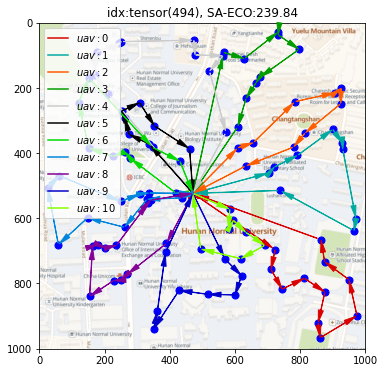

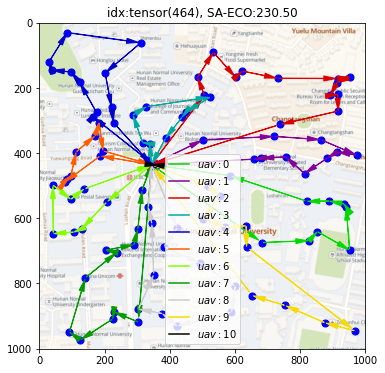

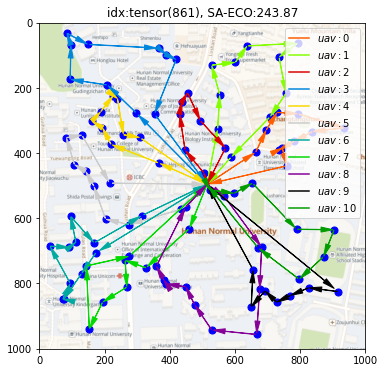

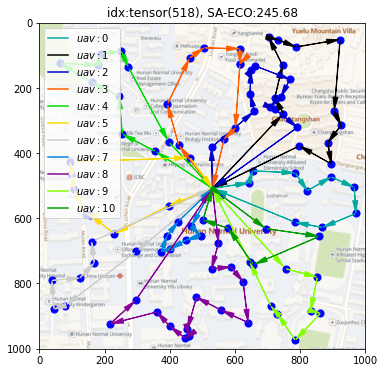

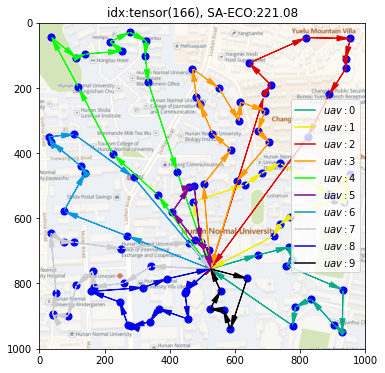

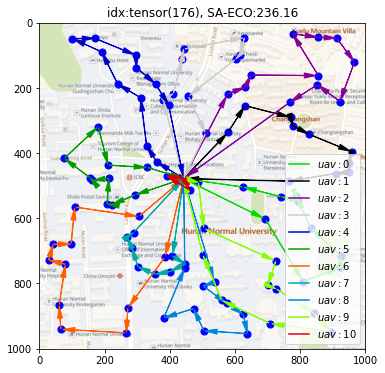

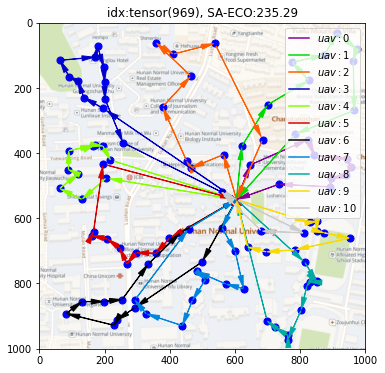

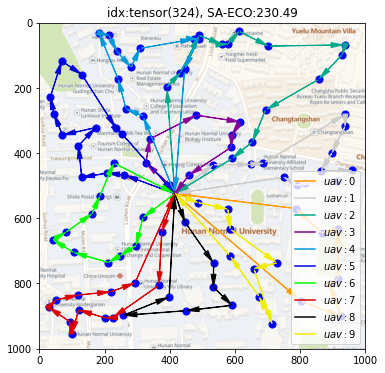

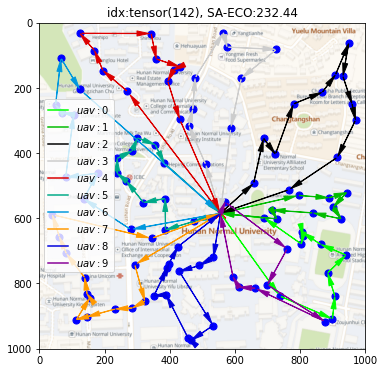

In [118]:
# idx = 10
start = 0
plot_num = 20
for idx in sort_length_idx[start:start+plot_num]:
    demand = batch['demand'].numpy()[idx]
    demand = np.append([0], demand)
    loc = batch['loc'].numpy()[idx]
    depot = batch['depot'].numpy()[idx]
    # depot = np.array([0.5, 0.5])
    loc = np.vstack((depot, loc))
    # print(loc.shape, demand.shape)
    result = tours[idx]
    #     print(result)
    draw(idx.numpy(), loc, depot, result, demand, connect_depot=True, 
         name='idx:{}, SA-ECO:{:.2f}'.format(str(idx), cal_work_single(length.numpy()[idx], sum(demand)) / 3600.0))
    print(' ========= ')

    uav     memory        battery        run time
0     0  493 / 512  884762 / 2550  8172.26 / 20.0
1     1  509 / 512  678886 / 2550  6269.91 / 20.0
2     2  503 / 512  993505 / 2550  9177.00 / 20.0
3     3  442 / 512  463565 / 2550  4280.68 / 20.0
4     4  490 / 512  881069 / 2550  8138.14 / 20.0
5     5  475 / 512  835541 / 2550  7717.57 / 20.0
6     6  470 / 512  598069 / 2550  5523.33 / 20.0
7     7  490 / 512  551068 / 2550  5088.93 / 20.0
8     8  502 / 512  890054 / 2550  8221.11 / 20.0
9     9  498 / 512  786557 / 2550  7264.85 / 20.0
10   10  242 / 512  360375 / 2550  3328.32 / 20.0


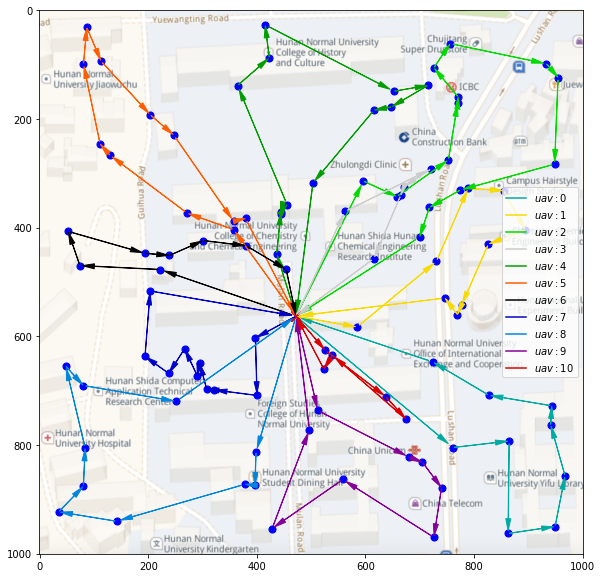

In [9]:
idx = 0
demand = batch['demand'].numpy()[idx]
demand = np.append([0], demand)
loc = batch['loc'].numpy()[idx]
depot = batch['depot'].numpy()[idx]
# depot = np.array([0.5, 0.5])
loc = np.vstack((depot, loc))
# print(loc.shape, demand.shape)
result = tours[idx]
#     print(result)
draw(idx, loc, depot, result, demand, figsize=(10, 10), is_draw=True, connect_depot=True, print_data=True, name=''.format(cal_work_single(length.numpy()[idx], sum(demand)) / 3600.0))
print(' ========= ')

In [12]:
def make_random_solution(loc, demand, gamma=1.0):
    dem = 1.0
    init_elec = 0.01
    elec = 1.0 - init_elec
    cur = loc[0]
#     gamma 选择最近节点or随机选择节点
    route = []
    vis = np.arange(1, len(loc))
    length = 0.0
    w1 = 0.5
    w2 = 0.25
    limit = len(vis) * 5
    while len(vis) != 0:
        if limit == 0:
            return 99999, None
        else:
            limit -= 1
        # dist_from_depot = np.sqrt(sum((cur - loc[vis[0]]) ** 2))
        # if elec - w2 * dist_from_depot 
        if np.random.rand() > gamma:
            # 随机选点
            idx = np.random.randint(low=0, high=len(vis))
        else:
            # 选择最近点
            # idx = np.argmin(np.sum((loc[vis] - cur) ** 2, axis=1))
            # available = []
            idx = -1
            min_dist = 99999
            flag = False
            for ava in range(len(vis)):
                if dem + 0.1 > demand[vis[ava]] and elec + 0.1 > w1 * (np.sqrt(sum((loc[vis[ava]] - cur) ** 2)) + np.sqrt(sum((loc[vis[ava]] - loc[0]) ** 2))) + w2 * demand[vis[ava]]:
                    # available.append(ava)
                    flag = True
                    if np.sqrt(sum((loc[vis[ava]] - cur) ** 2)) < min_dist:
                        min_dist = np.sqrt(sum((loc[vis[ava]] - cur) ** 2))
                        idx = ava
            if flag:
                # print(available[np.argmin(np.sum((loc[available] - cur) ** 2, axis=1))])
                # print('=======')
                # print(np.argmin(np.sum((loc[available] - cur) ** 2, axis=1)))
                # idx = available[np.argmin(np.sum((loc[available] - cur) ** 2, axis=1))]
                # idx = np.argwhere(vis == idx)[0][0]
                # print(idx)
                pass
            else:
                route.append(0)
                length += np.sqrt(sum((cur - loc[0]) ** 2))
                dem = 1.0
                elec = 1.0 - init_elec
                cur = loc[0]
                continue
        cur_length = np.sqrt(sum((cur - loc[vis[idx]]) ** 2))
        
        route.append(vis[idx])
        dem -= demand[vis[idx]]
        length += cur_length
        elec -= (w1 * cur_length + w2 * demand[vis[idx]])
        cur = loc[vis[idx]]
        vis = np.delete(vis, idx)
        # print(dem, elec)
    if cur[0] != loc[0][0] or cur[1] != loc[0][1]:
        length += np.sqrt(sum((cur - loc[0]) ** 2))
        
    return length, np.array(route)

    uav     memory        battery        run time
0     0  559 / 512  689511 / 2550  6367.81 / 20.0
1     1  551 / 512  671464 / 2550  6201.06 / 20.0
2     2  557 / 512  754961 / 2550  6972.56 / 20.0
3     3  531 / 512  851849 / 2550  7867.92 / 20.0
4     4  498 / 512  828216 / 2550  7649.78 / 20.0
5     5  535 / 512  867723 / 2550  8014.60 / 20.0
6     6  544 / 512  885064 / 2550  8174.78 / 20.0
7     7  477 / 512  971058 / 2550  8969.74 / 20.0
8     8  280 / 512  819028 / 2550  7566.04 / 20.0
9     9  260 / 512  978388 / 2550  9038.64 / 20.0
10   10  200 / 512  793326 / 2550  7329.01 / 20.0
11   11  130 / 512  811210 / 2550  7494.64 / 20.0


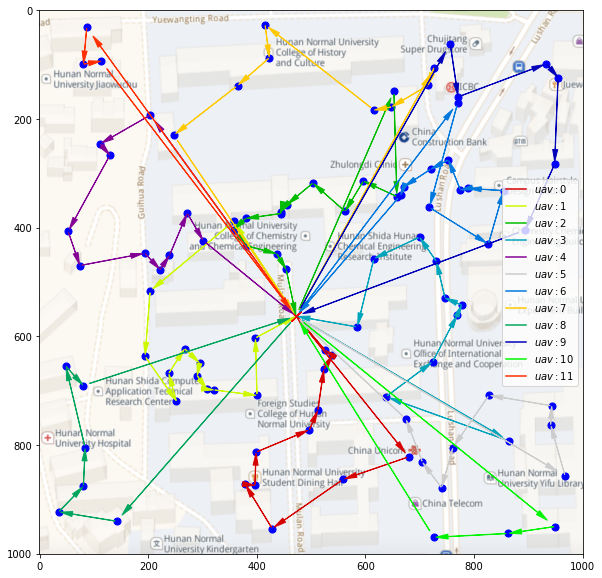

In [15]:
idx = 0
demand = batch['demand'].numpy()[idx]
demand = np.append([0], demand)
loc = batch['loc'].numpy()[idx]
depot = batch['depot'].numpy()[idx]
# depot = np.array([0.5, 0.5])
loc = np.vstack((depot, loc))
nn_length, result = make_random_solution(loc, demand)
draw(idx, loc, depot, result, demand, figsize=(10, 10), is_draw=True, connect_depot=True, print_data=True, name=''.format(cal_work_single(nn_length, sum(demand)) / 3600.0))
print(' ========= ')

In [128]:
idx = 940
demand = batch['demand'].numpy()[idx]
demand = np.append([0], demand)
loc = batch['loc'].numpy()[idx]
depot = batch['depot'].numpy()[idx]
# depot = np.array([0.5, 0.5])
loc = np.vstack((depot, loc))
# print(loc.shape, demand.shape)
result = tours[idx]
#     print(result)
draw(idx, loc, depot, result, demand, draw_route=False, fig_name='map_points.png', figsize=(10, 10), is_draw=True, connect_depot=True, print_data=True, name=''.format(cal_work_single(length.numpy()[idx], sum(demand)) / 3600.0))
print(' ========= ')

    uav     memory        battery        run time
0     0  503 / 512  826867 / 2550  7637.26 / 20.0
1     1  473 / 512  670360 / 2550  6191.30 / 20.0
2     2  481 / 512  755369 / 2550  6976.72 / 20.0
3     3  458 / 512  889171 / 2550  8213.22 / 20.0
4     4  495 / 512  696739 / 2550  6434.93 / 20.0
5     5  492 / 512  919579 / 2550  8493.97 / 20.0
6     6  504 / 512  562333 / 2550  5192.97 / 20.0
7     7  426 / 512  514120 / 2550  4747.92 / 20.0
8     8  475 / 512  649737 / 2550  6000.74 / 20.0
9     9  496 / 512  847102 / 2550  7824.28 / 20.0
10   10   70 / 512   80243 / 2550   740.84 / 20.0


In [109]:
invalid = []
for idx in range(100):
    demand = big_batch['demand'].numpy()[idx]
    demand = np.append([0], demand)
    loc = big_batch['loc'].numpy()[idx]
    depot = big_batch['depot'].numpy()[idx]
    # depot = np.array([0.5, 0.5])
    loc = np.vstack((depot, loc))
    # print(loc.shape, demand.shape)
    result = tours2[idx]
    #     print(result)
    draw(idx, loc, result, demand, is_draw=False, invalid=invalid, connect_depot=False, print_data=False)


In [110]:
np.sum(invalid)

0

In [56]:
colors

[(0.972535294117647, 0.8548882352941177, 0.0, 1.0),
 (0.0, 0.6130686274509803, 0.0, 1.0),
 (0.0, 0.0, 0.0, 1.0),
 (0.0, 0.853621568627451, 0.0, 1.0),
 (0.5176235294117647, 1.0, 0.0, 1.0),
 (0.0, 0.5215882352941177, 0.8667, 1.0),
 (0.0, 0.0, 0.7882686274509804, 1.0),
 (0.0, 0.6667, 0.6274647058823529, 1.0),
 (0.853621568627451, 0.0, 0.0, 1.0),
 (0.5202411764705882, 0.0, 0.5869215686274509, 1.0),
 (1.0, 0.36470588235294116, 0.0, 1.0)]

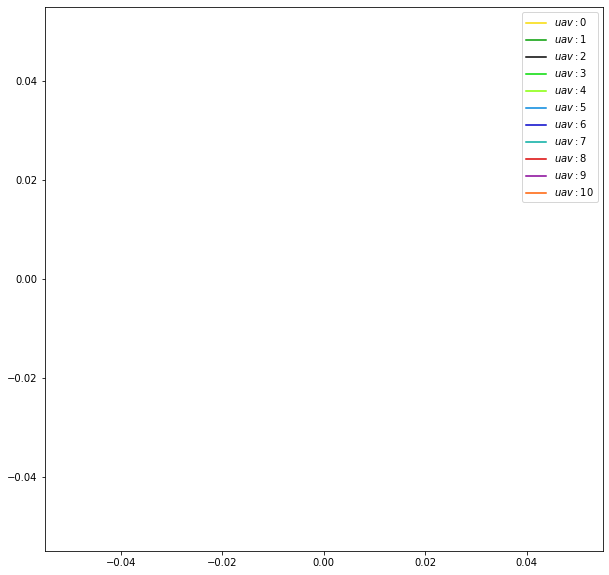

In [61]:
plt.figure(figsize=(10, 10))
# ax.set_color_cycle(colors)
for i, color in enumerate(colors):
    plt.plot(0, 0, color=color, label='$uav:{}$'.format(i))
    
plt.legend(loc='best')

In [125]:
for idx in range(10,11):
    
    demand = big_batch['demand'].numpy()[idx]
    demand = np.append([0], demand)
    loc = big_batch['loc'].numpy()[idx]
    depot = big_batch['depot'].numpy()[idx]
    loc = np.vstack((depot, loc))
    # print(loc.shape, demand.shape)
    result = tours2[idx]
#     print(result)
    draw(idx, loc, result, demand)
    print(' ========= ')

NameError: name 'big_batch' is not defined

tour 0


TypeError: len() of a 0-d tensor

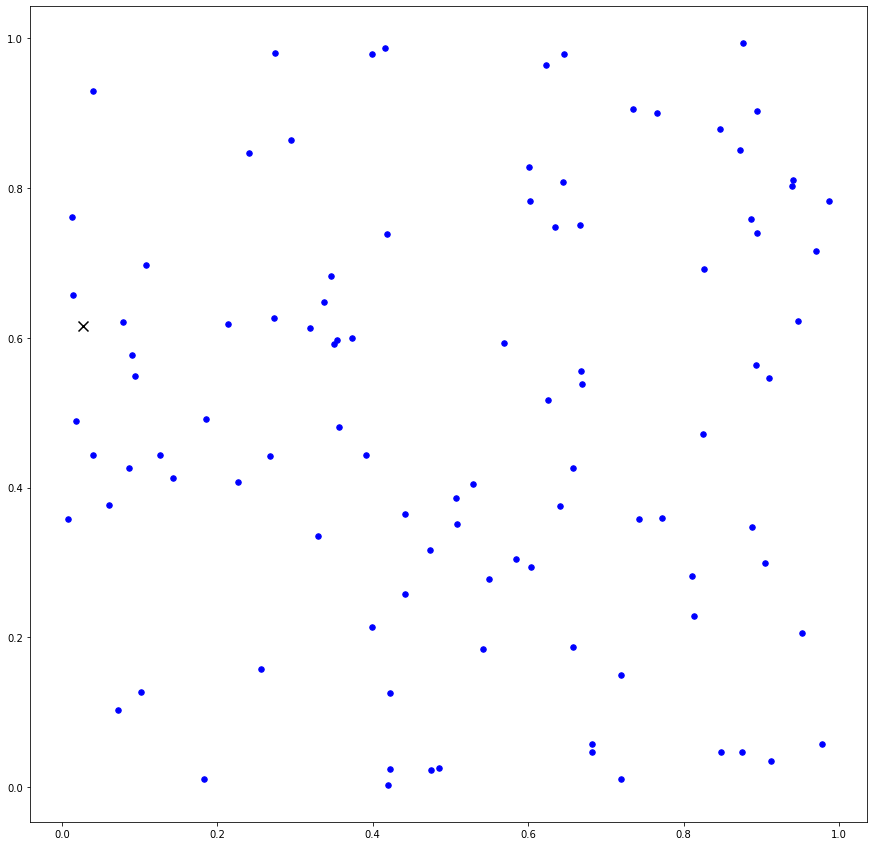

In [109]:
plt_idx = 0
plt.figure(num=0, figsize=(15, 15))
start = batch['depot'].numpy()[plt_idx]
plt.scatter(start[0], start[1], marker='x', c='black', s=100)
plt.scatter(batch['loc'].numpy()[plt_idx][:, 0], batch['loc'].numpy()[plt_idx][:, 1], c='blue', s=30)
tour_list = tours[plt_idx]
cmap = discrete_cmap(len(tour_list)+1, 'nipy_spectral')
cidx = np.random.permutation(len(tour_list)+1)
pts = batch['loc'].numpy()[0]
# plt.scatter(takeoff[0], takeoff[1], s=5, color='b')
for i in range(len(tour_list)):
    tour = tour_list[i] - 1
    print('tour', i)
    color = cmap(cidx[i])
    for j in range(len(tour)-1):
        xy = pts[tour[j]]
        xy2 = pts[tour[j+1]]
        
        plt.annotate('', xy=xy,xytext=xy2,arrowprops=dict(arrowstyle="->",connectionstyle="arc3",color=color))
    xy = start; xy2 = pts[tour[0]]
    plt.annotate('', xy=xy,xytext=xy2,arrowprops=dict(arrowstyle="->",connectionstyle="arc3",color=color))
    xy = pts[tour[len(tour) - 1]]; xy2 = start
    plt.annotate('', xy=xy,xytext=xy2,arrowprops=dict(arrowstyle="->",connectionstyle="arc3",color=color))
# plt.scatter(0.5, 0.5, marker='x')
# plt.savefig("myImages/AM.png")